In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')

import logging

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]

# NYC

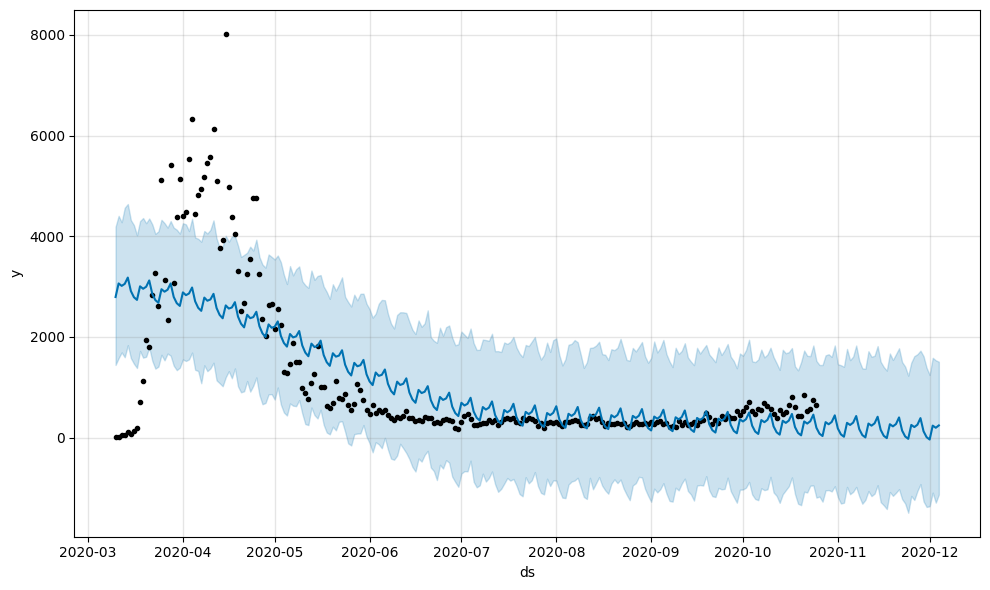

In [ ]:
nyc = data[data['entity'] == 'New York-New York City'].loc[:, ['date', 'incremental_cases']]
nyc['incremental_cases'] = nyc['incremental_cases'].astype('int')
nyc['date'] = pd.to_datetime(nyc['date'], format="%Y-%m-%d")
nyc = nyc.rename(columns = {'date':'ds', 'incremental_cases':'y'})

# use 85%-15% for train-test split
# NYC was checked to be stationary without differencing
train = nyc.iloc[:230, :]
test = nyc.iloc[230:, :]

model = Prophet().fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

In [ ]:
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

events = pd.concat((COVID, superbowl))

In [ ]:
train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 10],
    'holidays_prior_scale':[0.01, 0.1, 0.5, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 1619089.1636981042


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 1838656.4960127336


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 1882658.4254206188


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 1850915.0092041509


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 1837396.5741172722


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 1566308.0130053265


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 1854342.9613438144


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 2377474.165297492


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 2583662.9477009303


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 2283687.8054736643


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 1815996.2866158958


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 1893099.9099207472


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 1965277.655193935


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 1925187.4511122138


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 1951328.4325095026


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 1682412.106156862


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 2115398.8094392186


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 2428545.371122045


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 2380762.5218672077


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 2368151.297929912


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 4233687.105436944


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 4529216.751407969


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 4386422.279222997


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 4498629.519974172


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 4333742.621242803


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 4422518.907876625


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 4504355.6358673265


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 4507507.005146022


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 4640712.883173558


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 4682891.217636625


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 4617344.795533944


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 4921845.176299993


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 4691932.456468647


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 4775210.330009822


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 4802159.078277592


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 4695535.885512345


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 4785698.967648773


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 4858051.982826403


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 4685036.5277436515


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 4808438.390059651


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 4586512.95670832


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 4959045.539430565


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 4746793.189434681


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 4757664.829411834


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 4735235.496612288


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 4643299.691873948


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 4559042.08124899


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 4745101.195359374


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 4691956.580610293


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 4714172.282125082
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 1504185.5064151625
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 1641172.2772787597
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 1845197.9332206126
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 1801432.0150334283
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean M

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

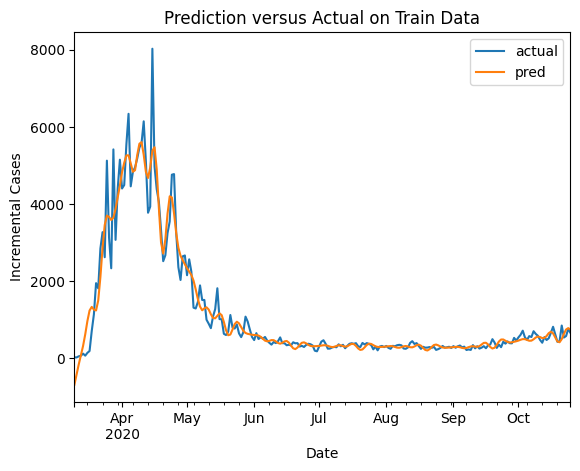

In [ ]:
model = Prophet(changepoint_prior_scale=0.5, holidays_prior_scale=1.0, seasonality_mode='multiplicative',
                seasonality_prior_scale=0.1, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.4588926595159428


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

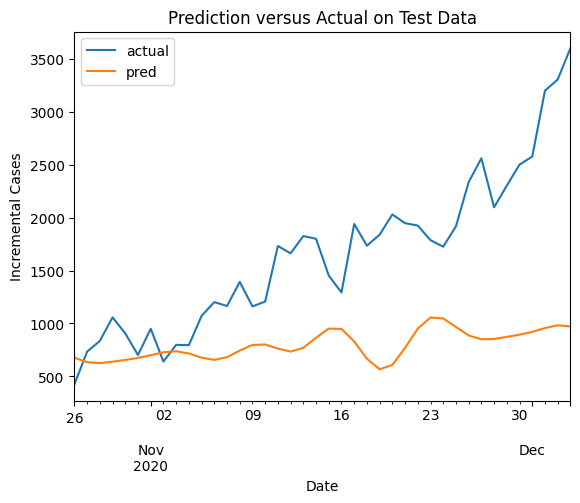

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.05, 0.1, 0.2, 0.3],
    'holidays_prior_scale':[0.5, 0.7, 1.0, 1.5, 2],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 279291.84322339523
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 298926.3530792485
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.2} with mean MSE: 290680.6883266662
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3} with mean MSE: 291295.3518797548
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 165290.0681247655
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 1

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

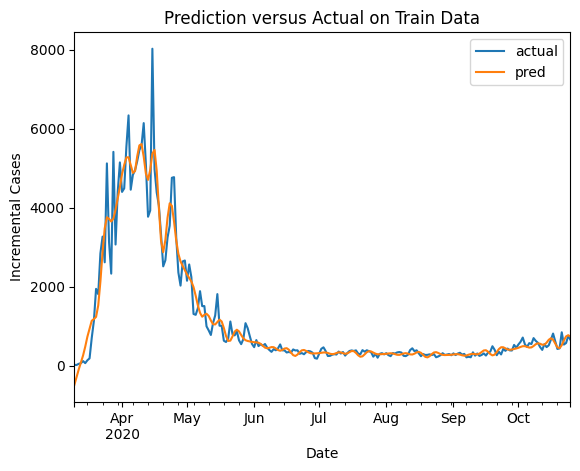

In [ ]:
model = Prophet(changepoint_prior_scale=1.0, holidays_prior_scale=0.7, seasonality_mode='multiplicative',
                seasonality_prior_scale=0.05, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.44511408644773354


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

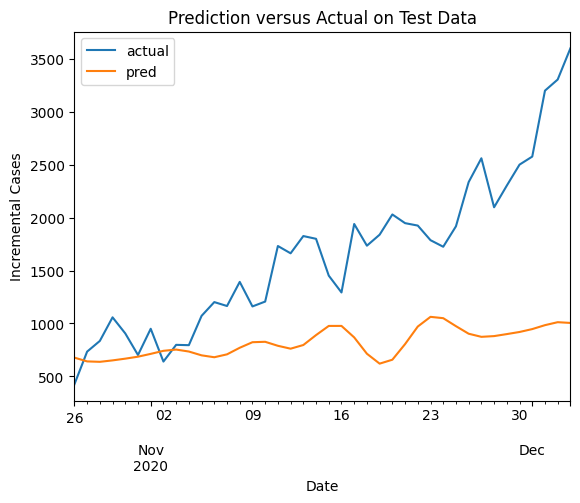

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [1.0, 2.0, 3.0, 4.0, 5.0],
    'seasonality_prior_scale': [0.01, 0.05, 0.1],
    'holidays_prior_scale':[0.6, 0.7, 0.8, 0.9, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 1.0, 'holidays_prior_scale': 0.6, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 103252.28839756145
params: {'changepoint_prior_scale': 1.0, 'holidays_prior_scale': 0.6, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 155369.17093233686
params: {'changepoint_prior_scale': 1.0, 'holidays_prior_scale': 0.6, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 161129.62417792506
params: {'changepoint_prior_scale': 1.0, 'holidays_prior_scale': 0.6, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 62764.71257677156
params: {'changepoint_prior_scale': 1.0, 'holidays_prior_scale': 0.6, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 62651.14353037692
params: {'changepoint_prior_scale': 1.0, 'holidays_prior_scale': 0.6, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with m

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

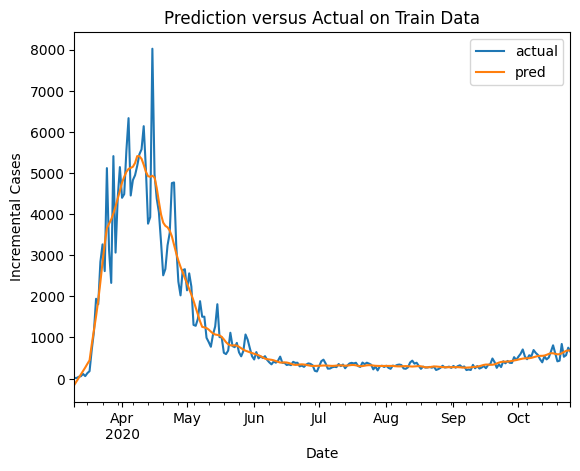

In [ ]:
model = Prophet(changepoint_prior_scale=5.0, holidays_prior_scale=0.6, seasonality_mode='multiplicative',
                seasonality_prior_scale=0.01, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.4257689016568774


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

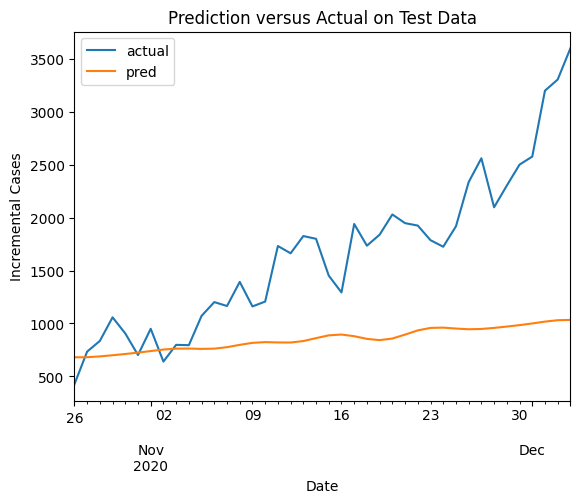

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [4, 5, 6, 7, 8],
    'seasonality_prior_scale': [0.001, 0.005, 0.01, 0.05],
    'holidays_prior_scale':[0.2, 0.4, 0.6, 0.8],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 4, 'holidays_prior_scale': 0.2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 48428.429575284885
params: {'changepoint_prior_scale': 4, 'holidays_prior_scale': 0.2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 53867.68578707841
params: {'changepoint_prior_scale': 4, 'holidays_prior_scale': 0.2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 67974.09321615899
params: {'changepoint_prior_scale': 4, 'holidays_prior_scale': 0.2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 113976.10548174514
params: {'changepoint_prior_scale': 4, 'holidays_prior_scale': 0.2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 52370.61752110802
params: {'changepoint_prior_scale': 4, 'holidays_prior_scale': 0.2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 4937

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

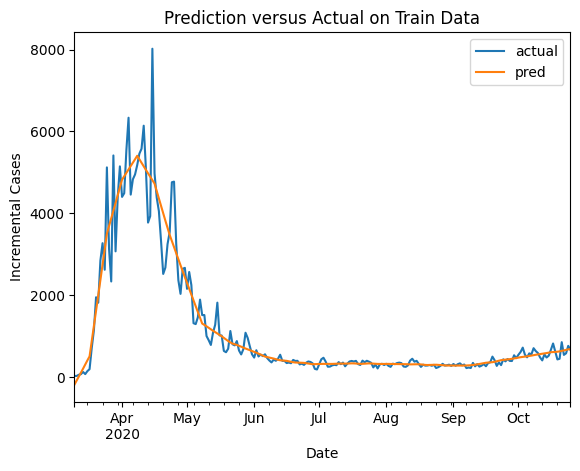

In [ ]:
model = Prophet(changepoint_prior_scale=8, holidays_prior_scale=0.2, seasonality_mode='additive',
                seasonality_prior_scale=0.001, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.4300507504603376


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

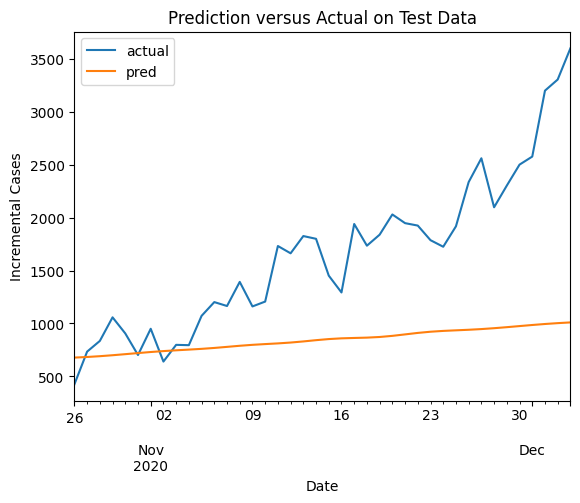

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [8, 10, 15, 20],
    'seasonality_prior_scale': [0.0001, 0.001, 0.01],
    'holidays_prior_scale':[0.1, 0.2, 0.3],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001} with mean MSE: 53664.10900107998
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 39853.01127046353
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 55779.75601169731
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001} with mean MSE: 65653.2446811023
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 42044.23890582575
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE:

# Clark

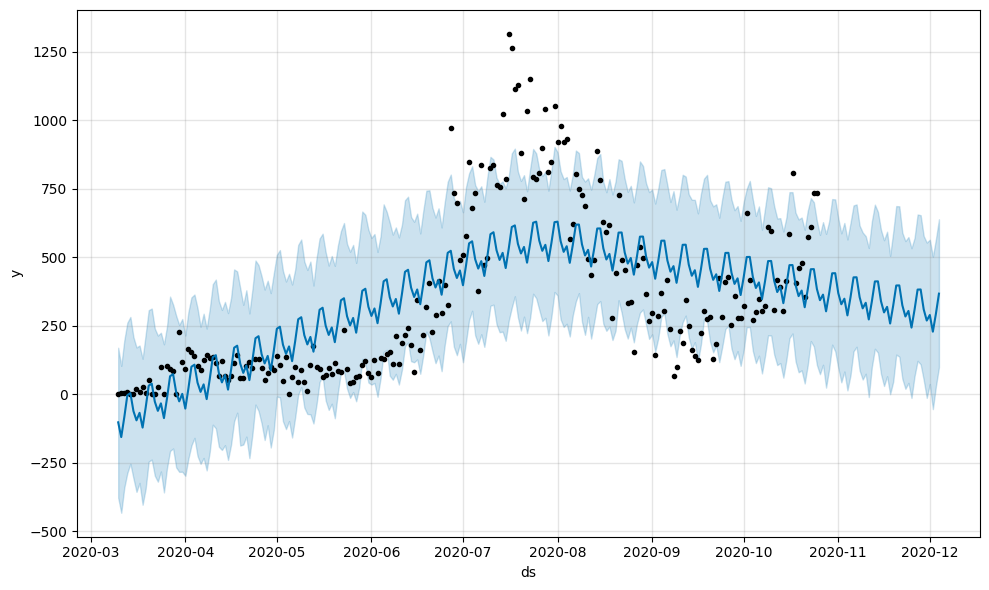

In [ ]:
clark = data[data['entity'] == 'Nevada-Clark'].loc[:, ['date', 'incremental_cases']]
clark['incremental_cases'] = clark['incremental_cases'].astype('int')
clark['date'] = pd.to_datetime(clark['date'], format="%Y-%m-%d")
clark = clark.rename(columns = {'date':'ds', 'incremental_cases':'y'})

# use 85%-15% for train-test split
# clark was checked to be stationary without differencing
train = clark.iloc[:230, :]
test = clark.iloc[230:, :]

model = Prophet().fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

In [ ]:
train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 10],
    'holidays_prior_scale':[0.01, 0.1, 0.5, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 274023.3084074625


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 279152.90438080305


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 281508.83792707924


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 279799.444478463


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 282355.62036177947


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 276768.198989857


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 269071.26903056586


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 278392.51641516713


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 284188.06427180814


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 293771.4559002058


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 263329.1920271753


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 269856.66283963574


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 287915.4640550549


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 277631.9852977118


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 280417.03867671854


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 274072.8541681127


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 266154.99096286


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 280348.6694025142


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 284437.3979610136


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 283523.58395887207


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 279408.4123925813


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 292354.86301664216


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 302634.0376260733


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 301268.44198089617


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 302308.59275568236


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 271339.3319356676


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 271926.0379716167


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 291199.9461322291


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 292149.3933545838


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 298441.08863029577


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 304155.5998227775


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 304665.5483187778


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 308983.58876238944


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 309135.93431445747


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 310459.53352300846


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 292942.8776399253


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 298699.6505576304


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 320385.57998814347


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 318398.8122904366


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 324067.4296319567


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 292682.070722026


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 306304.40626484697


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 307192.8609001696


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 307229.69611506176


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 307388.5846866803


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 298240.03834234114


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 319937.4336993744


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 290601.02801862964


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 320004.6065121828


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 317115.3791429039


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 282627.94636264513


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 266097.19448532024


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 277613.9567925054


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 271962.9862241061


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 269384.91707816196


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 277719.4212310275


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 278985.60949843633


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 282411.5403285669


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 281228.10407206335


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 288024.53954482096


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 275306.1089744506


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 275188.00762879977


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 270491.9015265354


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 273818.2483575426


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 279106.8261423555


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 252187.39634701214


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 270755.752570102


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 290015.57375689043


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 285337.7730823964


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 277612.2992134145


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 271224.71205266746


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 259160.68824018104


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 267986.21306157904


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 272204.5779090551


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 274960.1093382935


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 262845.66677521705


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 281962.8340708389


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 280885.3211621391


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 285087.82080437016


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 287900.28741878545


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 245553.0093039597


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 262561.1069399325


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 268801.36041811534


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 267700.17543928424


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 262775.6481465323


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 250839.2806782585


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 272075.9972575325


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 288950.1861809848


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 288725.90404734574


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 281840.22595033824


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 271690.7423588214


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 259829.84479481928


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 277281.8466988587


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 283138.4208149403


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 276076.7271916484


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 264422.10137221566


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 269971.8439428242


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 286661.9528702614


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 277352.9380249325
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 269644.57573220355
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 514896.2789789892
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 509951.9875985039
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 515946.10196560854
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE

-0.49142187238443036


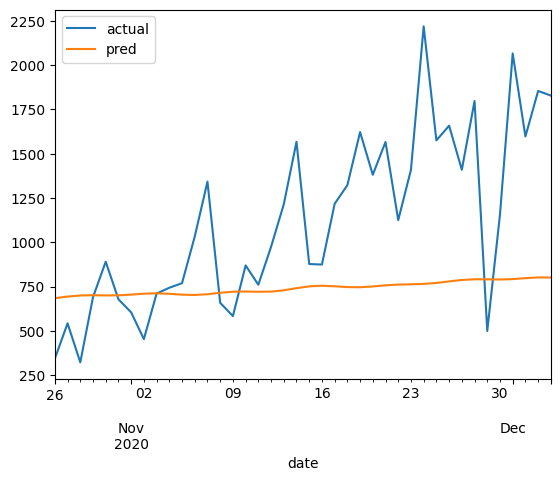

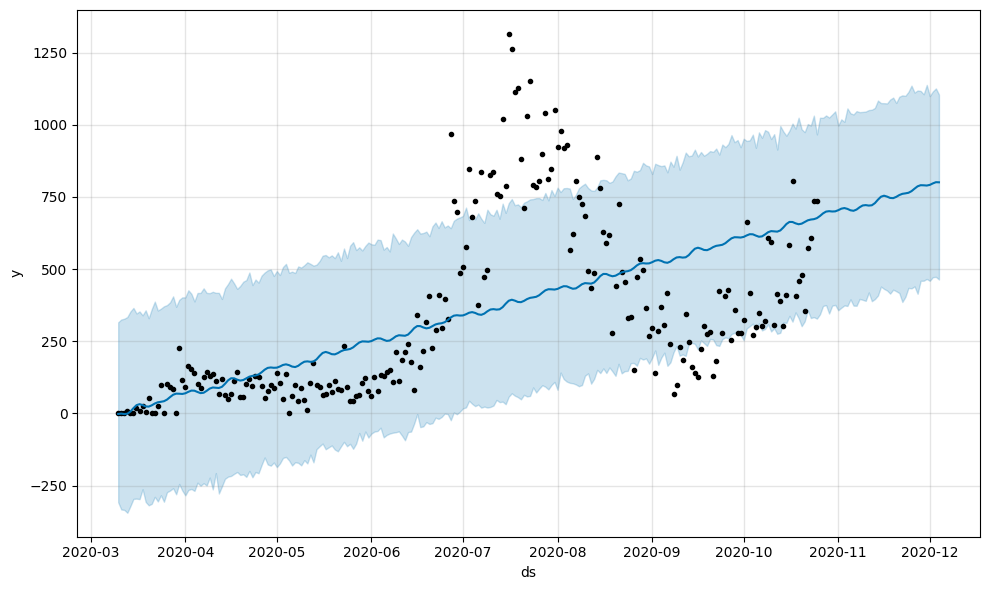

In [ ]:
model = Prophet(changepoint_prior_scale=0.01, holidays_prior_scale=1.0, seasonality_mode='additive',
                seasonality_prior_scale=0.01, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

model.plot(pred);

In [ ]:
train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.005, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [0.001, 0.005, 0.01, 0.05, 0.1],
    'holidays_prior_scale':[0.1, 0.5, 1, 2, 3],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 259845.38117236822


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 260503.0589158601


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 263329.1920271753


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 286789.91446489136


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 269856.66283963574


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 275391.65543174447


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 275076.7810642669


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 274072.8541681127


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 262409.1543023738


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 266154.99096286


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 279452.2575623793


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 273431.08164085547


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 279408.4123925813


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 301805.3583782474


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 292354.86301664216


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 272325.7094198856


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 272492.9246031964


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 271339.3319356676


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 277178.67484986637


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 271926.0379716167


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 307020.0202250946


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 307364.59953609813


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 304155.5998227775


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 309213.40531179815


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 304665.5483187778


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 299830.8658822782


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 298845.2181992528


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 292942.8776399253


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 299300.9751685346


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 298699.6505576304


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 293598.146615838


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 294127.98167806846


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 295397.1697874197


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 308452.1582786973


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 310094.4059929699


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 311603.1392164692


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 310575.3067112907


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 311855.08879352827


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 315222.28842127544


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 325878.09462564846


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 300837.73265274655


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 301276.1857963184


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 305523.5434791551


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 311204.23448751325


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 307689.40388327366


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 310690.29058699973


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 310925.0756642654


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 311643.13880335895


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 321288.72474405484


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 324570.7257702192


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 213776.5025426261


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 217076.82953650889


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 215409.28822411713


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 219698.95166532233


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 221648.77012789412


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 214255.1713071407


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 214074.9377209392


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 228860.88172094873


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 217908.94122725687


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 225131.17963127155


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 212983.1201547026


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 216542.96911205866


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 215136.73820335802


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 219894.95430880893


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 224875.61093570184


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 227822.02067161526


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 224638.54874610677


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 230029.4345236865


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 219632.79764392335


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 241207.52177509313


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 213205.69396841773


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 216343.65478633853


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 214833.11765755332


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 220662.12371898655


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 222089.28239055976


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 216050.08394982244


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 227196.94847254525


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 230457.2076087986


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 219965.95095296166


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 226314.32080075206


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 212706.64576740153


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 215307.86319115385


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 214780.14670785272


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 220667.65307507038


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 223571.6300776403


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 229045.50518884882


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 225420.04978495665


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 215813.94249454848


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 219452.42017177978


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 241756.73682381297


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 213100.51911830014


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 215930.6344324015


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 215152.73204861945


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 220173.33215706845


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 223080.77668982555


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 225963.01894811168


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 213957.03064179912


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 229304.45167997948


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 218970.16360750236


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 241562.22332689547


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 270652.6305052032


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 272122.84277697786


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 275306.1089744506


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 252549.71773667113


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 275188.00762879977


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 256543.56576872783


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 267111.03552175156


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 252187.39634701214


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 269575.02431554644


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 270755.752570102


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 247097.00735236358


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 265417.19170600636


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 271224.71205266746


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 275355.95994990814


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 259160.68824018104


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 252902.5117049145


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 249164.6614887803


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 262845.66677521705


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 265117.87688656774


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 281962.8340708389


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 260829.75683098251


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 263501.30883886915


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 245553.0093039597


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 272061.5631639979


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 262561.1069399325


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 270912.52239697747


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 257293.71726466098


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 250839.2806782585


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 264305.88540279504


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 272075.9972575325


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 251794.4687254821


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 274276.58640314924


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 288755.2432962749


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 268900.44805434626


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 260711.08370692632


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 244585.29559892285


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 262705.2268090169


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 264655.11977949983


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 269054.5113406615


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 270824.2334006549


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 262683.7953750169


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 257719.50562695807


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 272512.60692437686


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 282329.03086865455


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 258327.51643575708


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001} with mean MSE: 238695.23611133045


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 247899.09081060873


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 265998.85735302453


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 270063.3820337762
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 274223.61667506973
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001} with mean MSE: 371200.560451696
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 365404.8088056974
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 375778.4596334004
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean 

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

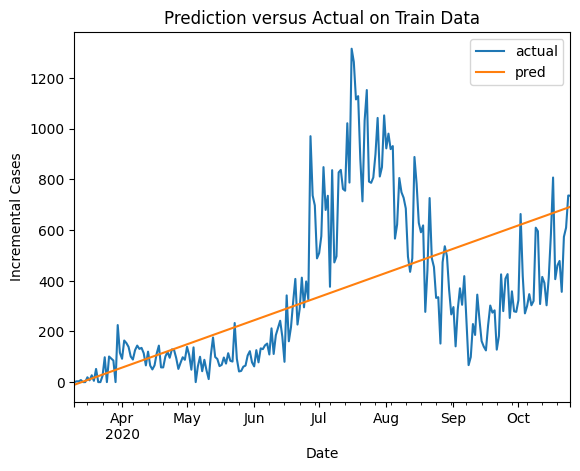

In [ ]:
model = Prophet(changepoint_prior_scale=0.005, holidays_prior_scale=2, seasonality_mode='additive',
                seasonality_prior_scale=0.001, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.37861465517606746


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

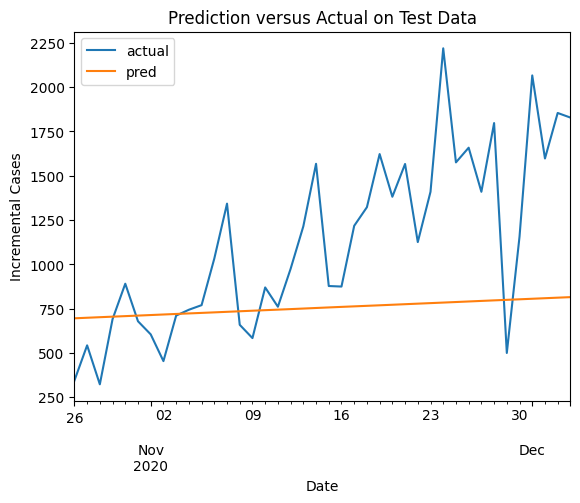

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.005, 0.01],
    'seasonality_prior_scale': [0.0001, 0.0005, 0.001, 0.005],
    'holidays_prior_scale':[1, 2, 3, 4, 5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality' : [True, False]
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 306999.4051518797


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 306999.907801214


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 306999.27648672264


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 307001.72742614354


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 307005.45878901094


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 307020.0202250946


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 306908.66935942246


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 307364.59953609813


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 299698.07060885505


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 299697.912218853


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 299610.59484595497


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 299814.77543149353


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 302400.3784340841


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 299830.8658822782


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 299962.76494550495


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 298845.2181992528


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 293575.79121013515


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 293575.9051117681


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 293579.6873040971


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 293580.033859717


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 293594.349341461


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 293598.146615838


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 294098.76806842984


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 294127.98167806846


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 311590.46103327227


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 311590.0966326552


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 311595.8352091703


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 311593.48244226427


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 311610.34723485477


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 311603.1392164692


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 310535.91127502365


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 310575.3067112907


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 300818.74756370246


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 300818.8264968742


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 300821.0917442261


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 300822.35696681327


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 300835.6718343466


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 300837.73265274655


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 304250.42269716767


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 301276.1857963184


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 310679.86870821577


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 310679.8700644408


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 310681.3399625176


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 310681.4570104414


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 310698.3928448232


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 310690.29058699973


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 311009.34352933086


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 310925.0756642654


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 302699.3876847436


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 302700.33577847417


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 302521.6648597271


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 302526.9803387401


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 302519.49384830653


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 302588.0406219083


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 302107.08711304836


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 303015.8429013011


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 312035.6162471338


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 312034.90927610523


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 312018.01935429295


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 312019.4166937116


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 312019.5586823121


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 312017.3464425052


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 311940.2918157616


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 311979.96114797314


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 301325.94862830534


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 301325.6396349932


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 301323.7720853833


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 301330.56742319505


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 301302.7490104557


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 301330.68276651646


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 299929.33566844644


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 301385.6274270453


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 302394.719998895


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 302400.33105844917


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 302355.92751943297


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 302361.02293273463


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 301953.5405846531


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 302298.0876470805


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 304505.5219082234


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 305553.2974469896


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 213845.20824867216


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 212788.33912542133


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 212664.02943157367


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 213603.0455510974


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 211615.56603030162


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 213205.69396841773


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 214611.7495955176


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 216343.65478633853


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 215974.1776314671


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 217571.98359370898


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 218269.92450569864


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 215133.80207442646


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 217175.81399432034


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 216050.08394982244


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 216212.04715071493


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 227196.94847254525


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 213342.60465260883


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 212581.19982792958


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 212200.0883889382


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 213143.32274456267


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 211066.67538694083


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 212706.64576740153


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 225391.18889456135


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 215307.86319115385


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 214710.9163776435


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 215778.83666012753


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 217123.38396251653


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 214295.0378263966


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 216575.5505892767


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 229045.50518884882


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 215010.50255021814


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 225420.04978495665


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 213815.11156207244


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 226274.43022737154


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 212596.98352760795


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 213590.22019895443


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 211555.90134041177


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 213100.51911830014


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 225792.71782357257


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 215930.6344324015


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 215068.737741578


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 214245.40524359568


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 216512.9405784252


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 213407.18940018234


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 216221.62988516354


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 225963.01894811168


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 214644.52555849636


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 213957.03064179912


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 213411.86851512745


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 211419.81267965134


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 212219.1108611862


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 213189.11913858817


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 211108.86115262075


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 212724.2643124483


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 225268.75808794665


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 215665.78169047748


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 213591.74389683982


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 214642.96391062482


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 215266.69460497765


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 212141.55470384282


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 213733.64771530617


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 213097.9072755465


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 214291.3911059238


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 224177.58853853625


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 213755.1024359941


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 211509.230743221


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 212381.0950798299


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 213343.3734739876


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 211236.20421455047


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 212885.7373698993


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 225613.7630223631


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 215960.52809102065


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 215069.05279493696


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 215010.5767398912


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 216275.73179151086


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 213599.38814233438


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 216755.56435897117


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 214567.95793153663


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 214777.56622526128


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 225138.29600446104


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 229326.76816429573


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 224801.02811781727


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 280250.45878329565


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 232506.9433284885


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 257408.37946943427


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 260829.75683098251


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 250143.7466179284


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 263501.30883886915


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 212876.34497263096


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 239455.09797001226


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 251130.20751587328


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 266109.090084831


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 257832.83631050904


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 270912.52239697747


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 265784.38524355897


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 257293.71726466098


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 250848.6256632686


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 242152.1070548572


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 280071.38396300946


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 249507.07506583785


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 253198.45393946682


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 251794.4687254821


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 254021.906655068


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 274276.58640314924


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 231709.88965069735


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 240501.57566572595


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 257134.78890143518


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 243347.65702019283


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 255722.485625434


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 244585.29559892285


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 251814.63449256704


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 262705.2268090169


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 242359.44327180088


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 251282.44065955825


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 265782.89359244105


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 241265.1334878792


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 255778.35415804328


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 262683.7953750169


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 246021.45724738677


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 257719.50562695807


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 233879.6184522003


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 229203.5649745681


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 253271.53434435904


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 245044.50608840425


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 223054.4676862684


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 238695.23611133045


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 257489.00255496148


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 247899.09081060873


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 238613.53577120023


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 238803.1769532724


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 265065.6694502332


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 261407.79361549407


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 250289.93387356735


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 265631.2732996772


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 254603.37296239426


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 272062.29489299137


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 240279.39900735024


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 231807.91122831698


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 238468.75682827688


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 253110.01342609385


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 258067.46177580263


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 260119.728642475


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 259321.44816058883


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 280551.2949069533


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 221088.74210054055


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 250155.36031630702


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 260695.65042939596


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 249755.17650425434


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 236992.6862734982


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 262690.74414039095


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 241302.99068118693


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 266059.16165508376


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': True} with mean MSE: 218697.36628652542


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0001, 'weekly_seasonality': False} with mean MSE: 246268.0916274848


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': True} with mean MSE: 245429.15388422261


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.0005, 'weekly_seasonality': False} with mean MSE: 257809.63355417736


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 260298.46641046545


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': False} with mean MSE: 255135.5098715891


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': True} with mean MSE: 256682.48555857953
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005, 'weekly_seasonality': False} with mean MSE: 262011.81390374564
Best Prophet parameters: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True} with mean MSE: 211066.67538694083


-0.44873438780228003


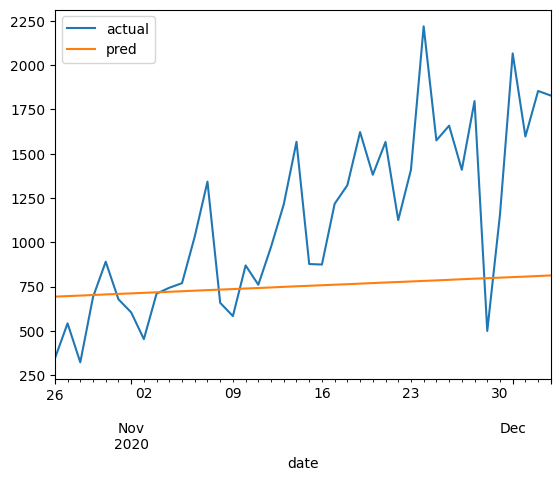

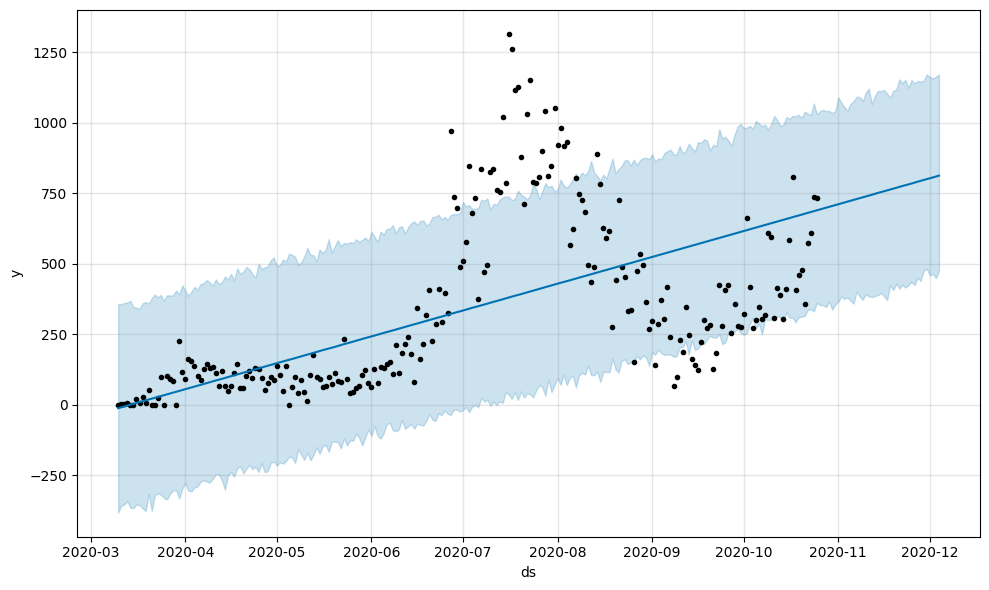

In [ ]:
model = Prophet(**best_param, yearly_seasonality = False,
                     daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

model.plot(pred);

# Suffolk

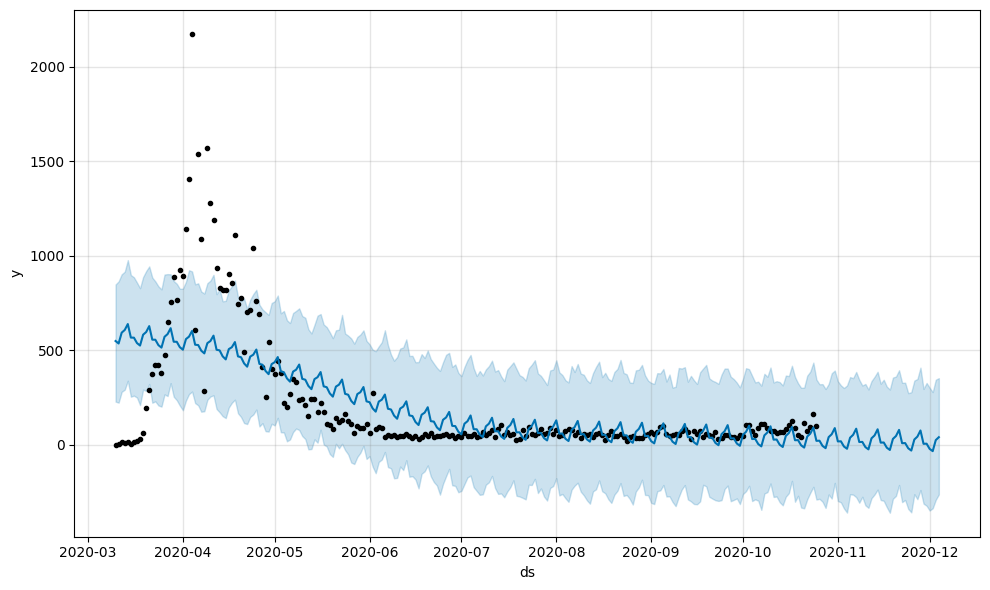

In [ ]:
suffolk = data[data['entity'] == 'New York-Suffolk'].loc[:, ['date', 'incremental_cases']]
suffolk['incremental_cases'] = suffolk['incremental_cases'].astype('int')
suffolk['date'] = pd.to_datetime(suffolk['date'], format="%Y-%m-%d")
suffolk = suffolk.rename(columns = {'date':'ds', 'incremental_cases':'y'})

# use 85%-15% for train-test split
# clark was checked to be stationary without differencing
train = suffolk.iloc[:230, :]
test = suffolk.iloc[230:, :]

model = Prophet().fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

In [ ]:
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

train = train.reset_index().drop(columns = 'index')

# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

events = pd.concat((COVID, superbowl))

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 10],
    'holidays_prior_scale':[0.01, 0.1, 0.5, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 136616.6265187284


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 134089.72560180008


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 133219.90117801607


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 134758.2954253572


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 134809.8448951074


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 136586.61747089087


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 149417.43708749212


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 176047.3064990095


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 182153.00222575082


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 181025.5483003933


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 139386.19560497697


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 137526.19417307733


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 138793.86905719704


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 136158.40638718943


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 137375.38620686025


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 137853.90793453518


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 152223.23777040042


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 178500.24384808974


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 190852.55873818242


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 183255.82863947473


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 225634.3873023026


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 229343.7946141983


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 226483.07243650258


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 234252.83207703996


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 234001.60691741086


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 243131.9520674744


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 248986.79109144365


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 244772.37518607941


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 250637.7614138686


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 243327.99722688863


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 243813.55212105476


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 247883.39551419215


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 246108.259894177


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 244656.82662442853


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 246150.2604328158


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 244817.34641310605


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 248229.7665441149


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 250265.96130368006


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 247915.3399836264


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 250266.0163127644


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 249303.84729732844


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 252712.73103184812


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 251322.11873275522


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 252978.43451172436


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 259066.31304972782


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 257563.4303591739


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 251158.6229956549


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 242859.3506290689


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 247251.50658702975
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 246634.93805126243
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 51091.37530670509
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 46094.09879692586
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 50070.35762774312
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with me

-1.220826670183198


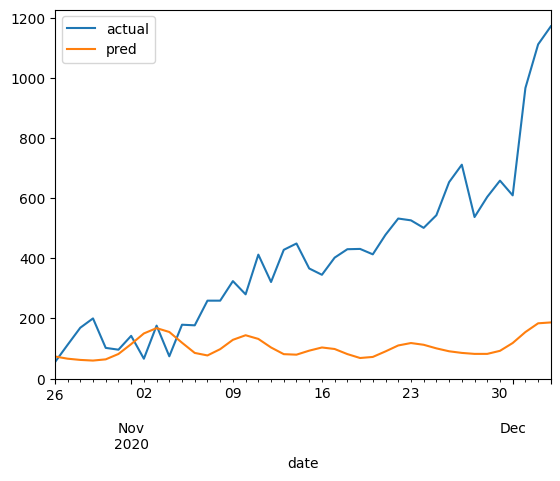

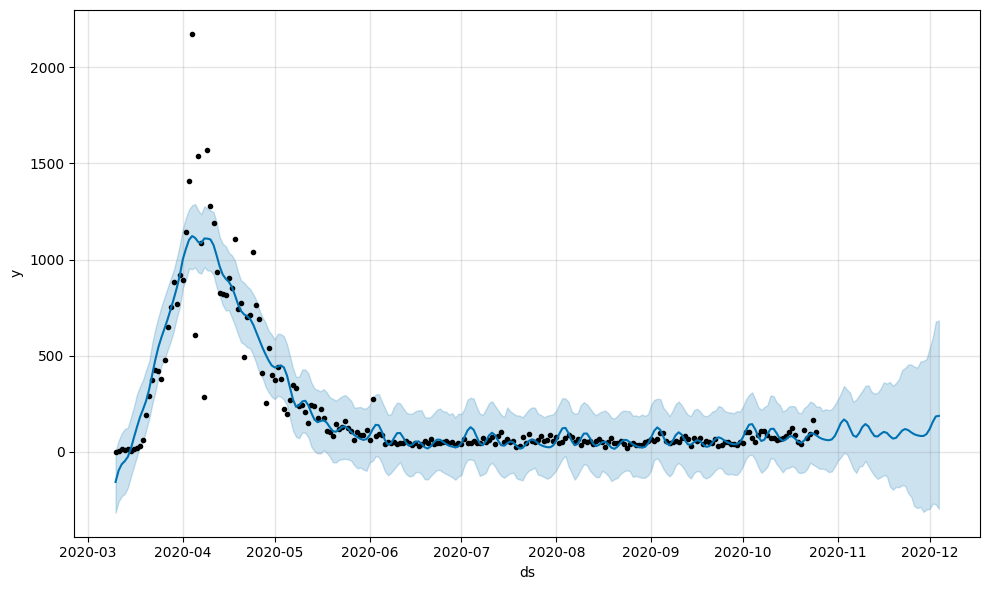

In [ ]:
model = Prophet(changepoint_prior_scale=0.5, holidays_prior_scale=0.01, seasonality_mode='additive',
                seasonality_prior_scale=1.0, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

model.plot(pred);

In [ ]:
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

train = train.reset_index().drop(columns = 'index')

# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

events = pd.concat((COVID, superbowl))

param_grid = {
    'changepoint_prior_scale': [0.1, 0.5, 1, 2, 3],
    'seasonality_prior_scale': [0.1, 0.5, 1, 2, 3],
    'holidays_prior_scale':[0.001, 0.005, 0.01, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 18882.15892411524
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 15569.523941682148
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1} with mean MSE: 19730.762142614905
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2} with mean MSE: 15111.646073642201
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3} with mean MSE: 12765.502705432618
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

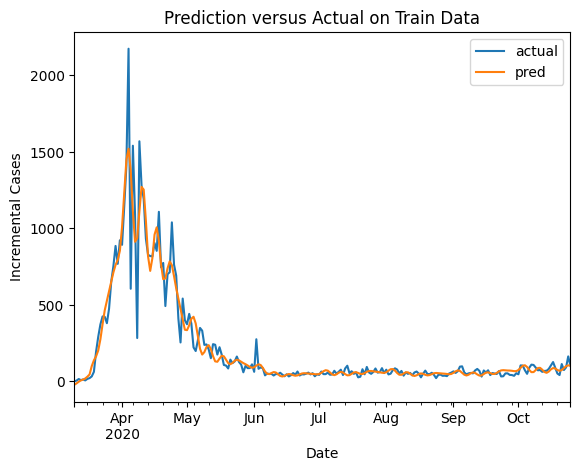

In [ ]:
model = Prophet(**best_param, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.6592020706127845


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

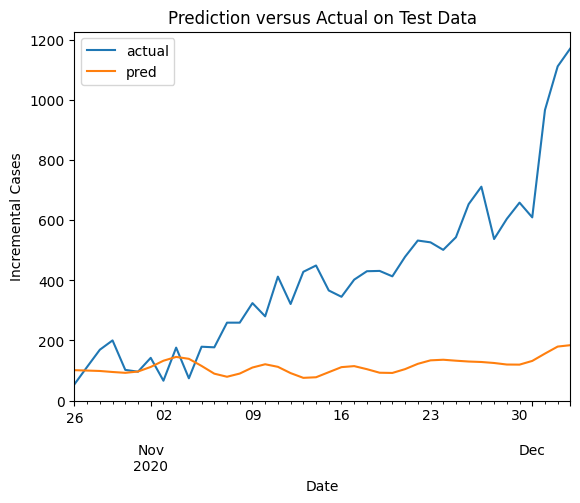

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [1, 3, 5, 10],
    'seasonality_prior_scale': [0.1, 0.3, 0.5, 0.7, 1],
    'holidays_prior_scale':[0.01, 0.05, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 2310.1011990032234
params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3} with mean MSE: 2285.960647013699
params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 2259.1282634931526
params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7} with mean MSE: 2288.942276807866
params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1} with mean MSE: 2479.429160334046
params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 3378.31626799322

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

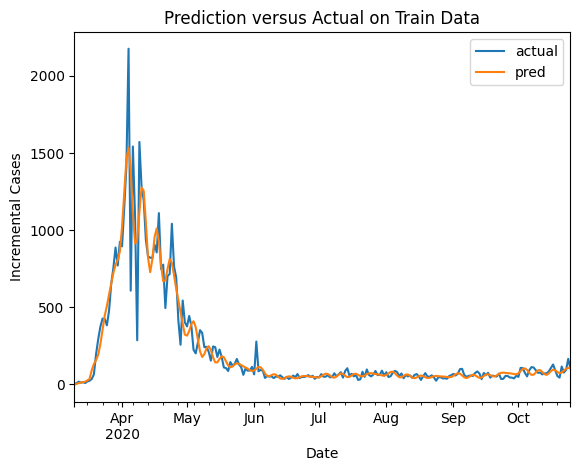

In [ ]:
model = Prophet(**best_param, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.6605372431970185


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

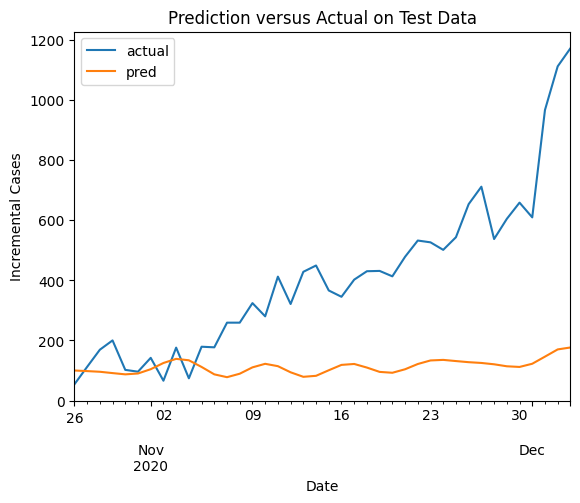

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [8, 10, 12, 14],
    'seasonality_prior_scale': [0.5, 0.6, 0.7, 0.8, 0.9],
    'holidays_prior_scale':[0.001, 0.005, 0.01, 0.05],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 3474.803843453212
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.6} with mean MSE: 4081.785527213801
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7} with mean MSE: 4205.58222855781
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.8} with mean MSE: 3645.700944888699
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.9} with mean MSE: 3132.951309173474
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 1540.992583

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

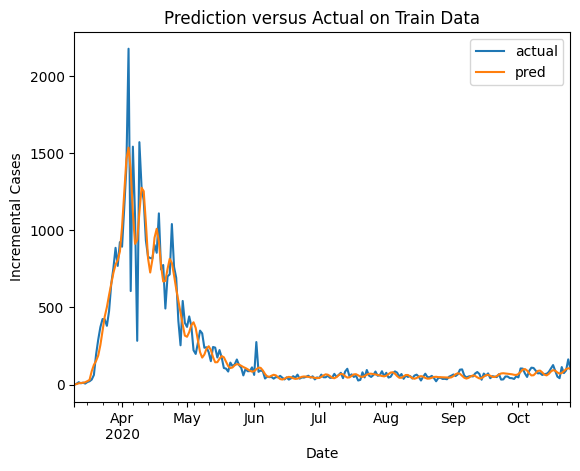

In [ ]:
model = Prophet(**best_param, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.6595057983490366


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

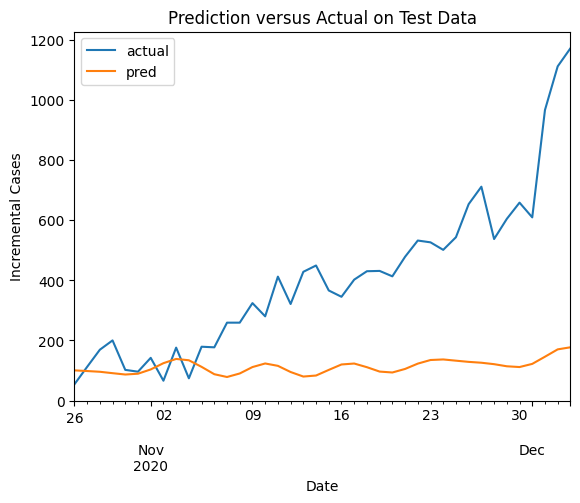

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [14, 16, 18],
    'seasonality_prior_scale': [0.1, 0.3, 0.5],
    'holidays_prior_scale':[0.0001, 0.0005, 0.001, 0.005],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 14, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 3907.9756136460837
params: {'changepoint_prior_scale': 14, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3} with mean MSE: 10912.901660412113
params: {'changepoint_prior_scale': 14, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 7803.243578932906
params: {'changepoint_prior_scale': 14, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 558.6426538543054
params: {'changepoint_prior_scale': 14, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.3} with mean MSE: 796.4125180661244
params: {'changepoint_prior_scale': 14, 'holidays_prior_scale': 0.0001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

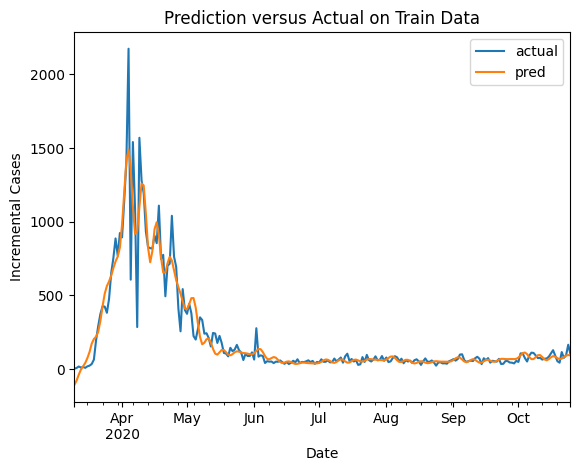

In [ ]:
model = Prophet(**best_param, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.6660704487766088


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

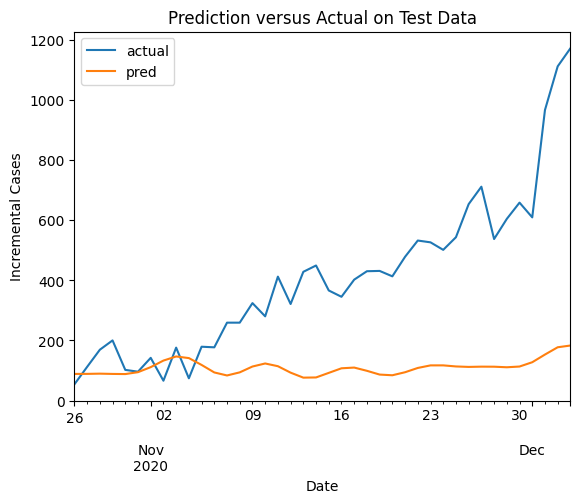

In [ ]:
pred = model.predict(test.drop(columns = 'y'))
mape = mean_absolute_percentage_error(test.y, pred.yhat)
print(mape)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
model = Prophet(changepoint_prior_scale=16, seasonality_mode='multiplicative',
                seasonality_prior_scale=0.3, yearly_seasonality = False,
                      weekly_seasonality = False, daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(train.drop(columns = 'y'))

prediction = pd.DataFrame({'actual':train.y.reset_index(drop = True),
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = train['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 10],
    'holidays_prior_scale':[0.01, 0.1, 0.5, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality':[True, False]
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 144338.67729655467


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 136616.6265187284


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 139448.00388364005


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 134089.72560180008


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 137939.67913030114


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 133219.90117801607


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 138122.8645571722


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 134758.2954253572


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 138059.90425031973


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 134809.8448951074


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 137601.78402892256


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 136586.61747089087


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 151857.49666409948


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 149417.43708749212


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 169224.48443827688


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 176047.3064990095


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 184318.13255682017


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 182153.00222575082


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 195117.0187713711


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 181025.5483003933


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 147064.12170445392


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 139386.19560497697


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 143444.05682534518


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 137526.19417307733


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 145280.0397912687


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 138793.86905719704


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 144277.5217575327


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 136158.40638718943


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 143942.80784021268


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 137375.38620686025


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 138846.064406453


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 137853.90793453518


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 155088.11838431933


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 152223.23777040042


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 168257.10946399998


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 178500.24384808974


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 185915.3355748212


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 190852.55873818242


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 192310.10590688922


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 183255.82863947473


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 241548.3706784759


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 225634.3873023026


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 246222.11475914004


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 229343.7946141983


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 239152.65217355065


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 226483.07243650258


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 246649.37373069394


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 234252.83207703996


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 245832.1483104955


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 234001.60691741086


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 245550.27278770585


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 243131.9520674744


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 253097.1954058921


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 248986.79109144365
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 249267.4552465677


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 244772.37518607941


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 250601.0473962434


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 250637.7614138686


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 254481.7302146617


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 243327.99722688863


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 253699.06071928752


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 243813.55212105476


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 255693.24670796227


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 247883.39551419215


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 260141.16768705938


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 246108.259894177


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 257783.92717372044


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 244656.82662442853


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 259871.99992588814


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 246150.2604328158


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 246252.71101925152


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 244817.34641310605


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 251161.2116241757


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 248229.7665441149


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 251996.09936635967


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 250265.96130368006


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 252005.03666252052


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 247915.3399836264


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 264021.83475005004


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 250266.0163127644


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 265035.70854133746


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 249303.84729732844


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 260811.99099737647


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 252712.73103184812


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 266502.73326277226


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 251322.11873275522


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 265724.6046666044


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 252978.43451172436


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 265353.0353796056


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 259066.31304972782


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 258612.9215933485


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 257563.4303591739


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 255145.9852960922


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 251158.6229956549


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 243137.14739390867


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 242859.3506290689


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 243575.44233960463


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 247251.50658702975


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 253069.49149675618
params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 246634.93805126243
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 42026.65442359285
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 51091.37530670509
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 44341.40825814238
p

-1.220826670183198


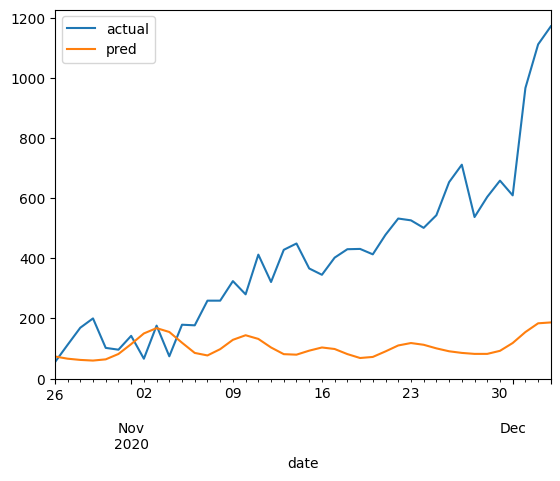

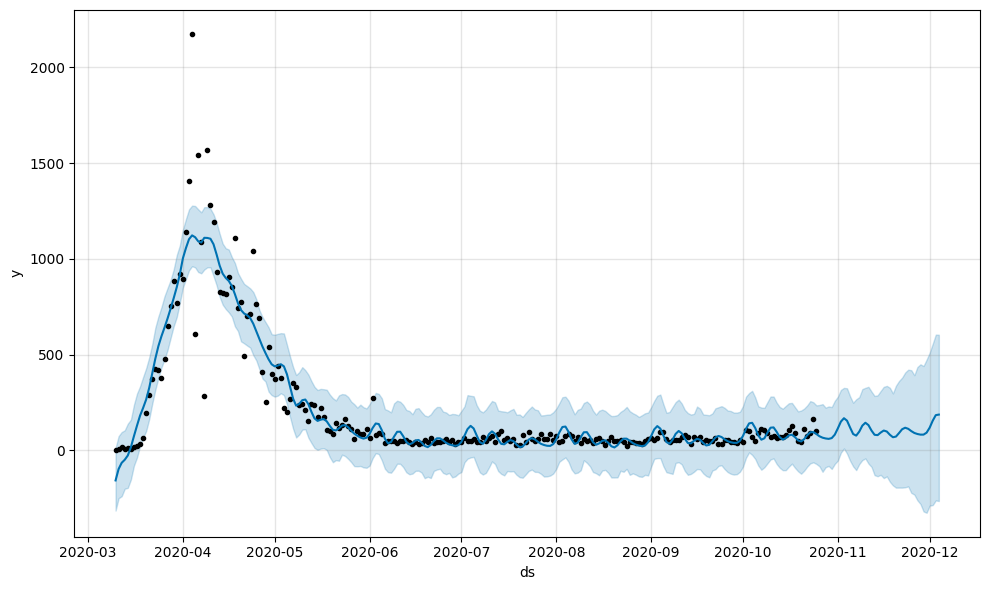

In [ ]:
model = Prophet(**best_param, yearly_seasonality = False,
                daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

model.plot(pred);

In [ ]:
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.1, 0.5, 1, 5],
    'seasonality_prior_scale': [0.1, 0.5, 1.0, 2, 3],
    'holidays_prior_scale':[0.001, 0.005, 0.01, 0.1],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality':[True, False]
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 16828.546471103047
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 18882.15892411524
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 18027.472611497997
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 15569.523941682148
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 19292.17885867388
params: {'

-1.1339829528753023


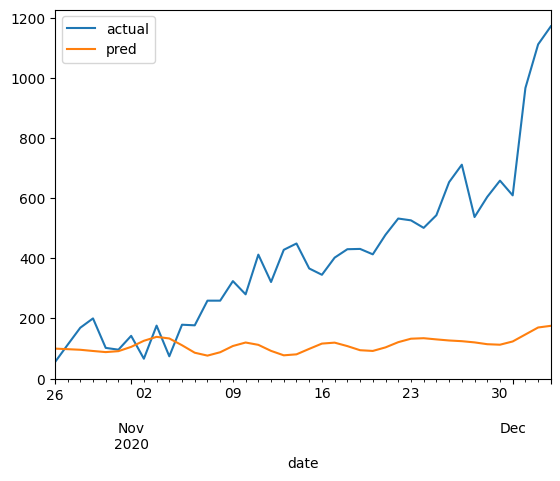

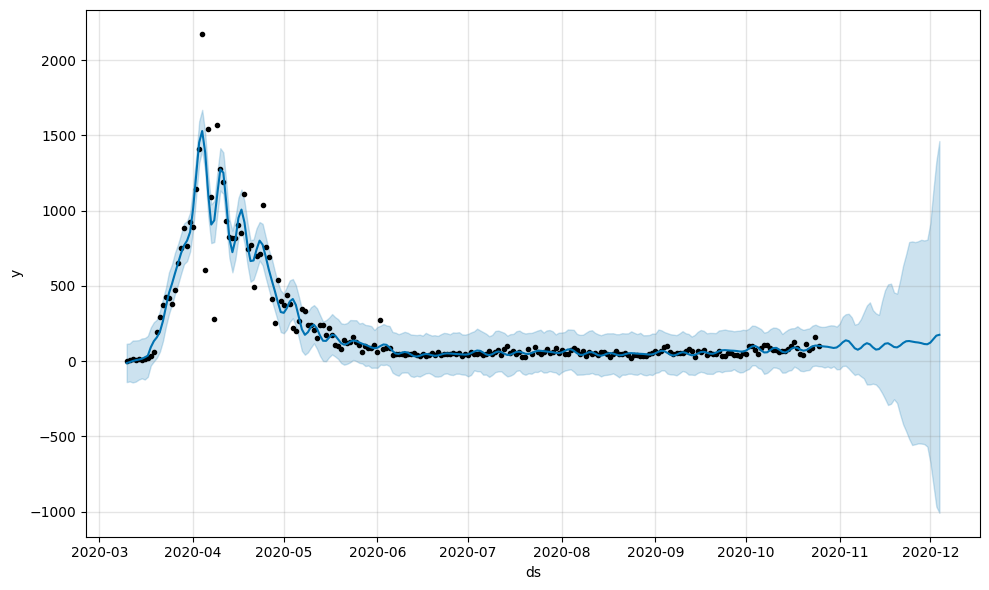

In [ ]:
model = Prophet(**best_param, yearly_seasonality = False,
                daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

model.plot(pred);

In [ ]:
param_grid = {
    'changepoint_prior_scale': [4, 5, 6, 7, 8],
    'seasonality_prior_scale': [1, 2, 3],
    'holidays_prior_scale':[0.008, 0.01, 0.03, 0.05],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality':[True, False]
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 4, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1, 'weekly_seasonality': True} with mean MSE: 5798.599593317824
params: {'changepoint_prior_scale': 4, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1, 'weekly_seasonality': False} with mean MSE: 2544.7469954766634
params: {'changepoint_prior_scale': 4, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2, 'weekly_seasonality': True} with mean MSE: 5377.450160453284
params: {'changepoint_prior_scale': 4, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2, 'weekly_seasonality': False} with mean MSE: 2231.6901283759967
params: {'changepoint_prior_scale': 4, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3, 'weekly_seasonality': True} with mean MSE: 5815.789107496573
params: {'changepoint_prior_sca

-1.1377933736768746


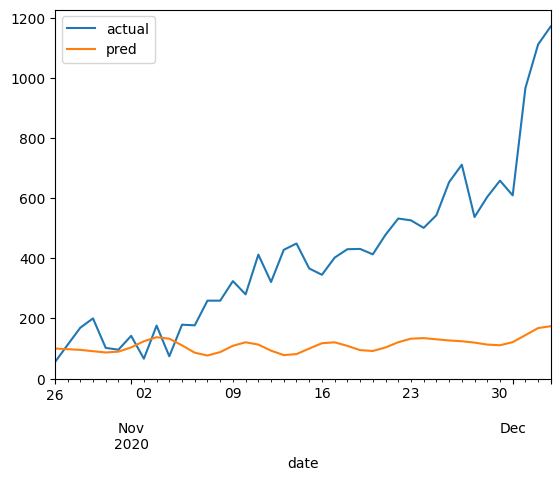

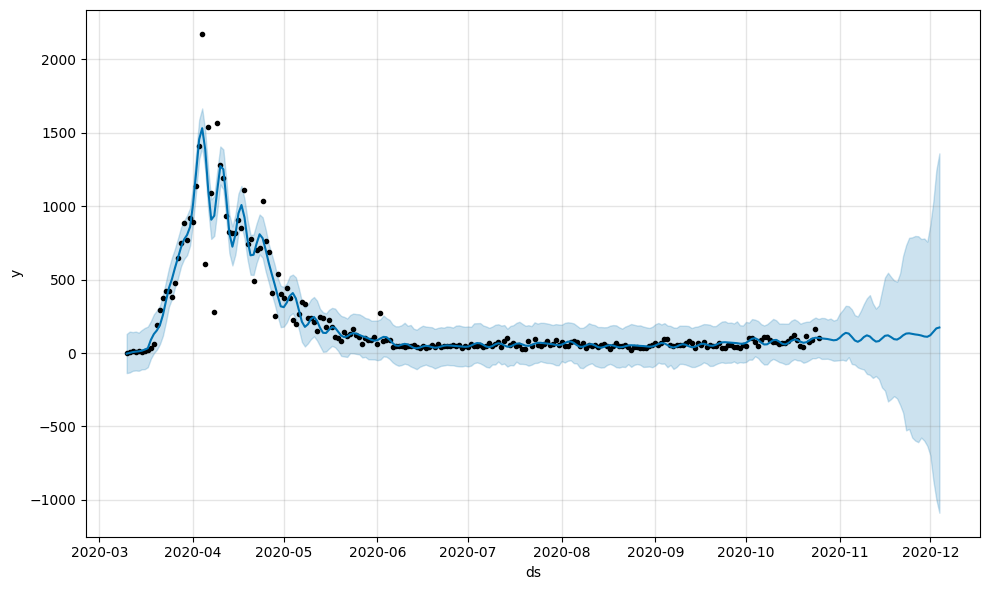

In [ ]:
model = Prophet(**best_param, yearly_seasonality = False,
                daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

model.plot(pred);

In [ ]:
param_grid = {
    'changepoint_prior_scale': [8, 10, 12],
    'seasonality_prior_scale': [3, 4, 5],
    'holidays_prior_scale':[0.008, 0.01, 0.03],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality':[True, False]
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3, 'weekly_seasonality': True} with mean MSE: 8511.052605067578
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3, 'weekly_seasonality': False} with mean MSE: 2188.19162063295
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4, 'weekly_seasonality': True} with mean MSE: 8484.719556449598
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4, 'weekly_seasonality': False} with mean MSE: 1882.875834327051
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5, 'weekly_seasonality': True} with mean MSE: 10091.78926795534
params: {'changepoint_prior_scale'

-1.1316971395756301


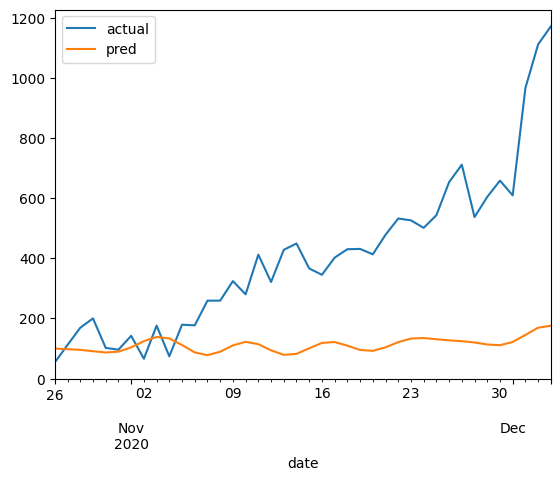

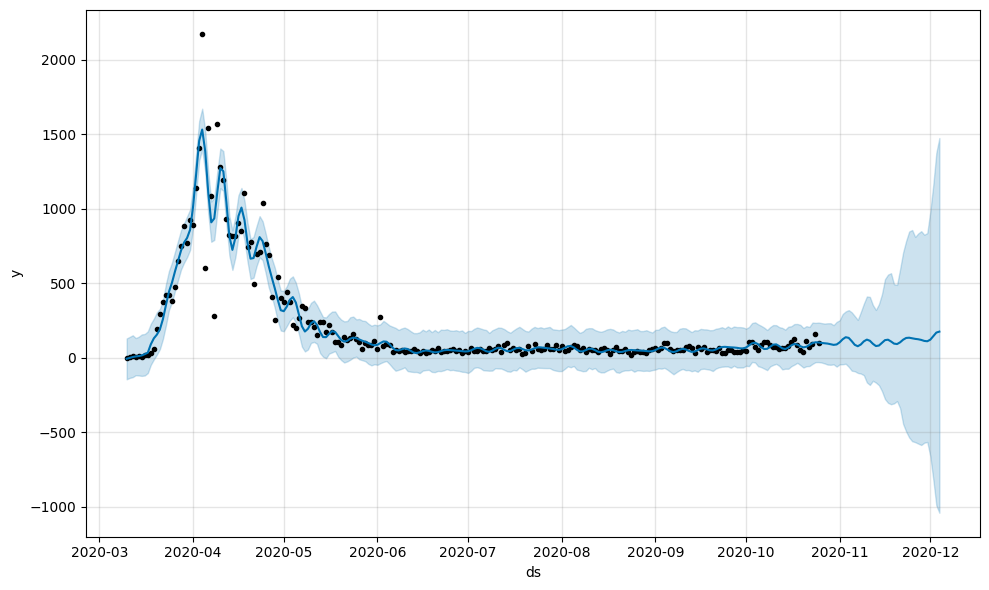

In [ ]:
model = Prophet(**best_param, yearly_seasonality = False,
                daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

model.plot(pred);

In [ ]:
param_grid = {
    'changepoint_prior_scale': [6, 8, 10],
    'seasonality_prior_scale': [2, 3, 4],
    'holidays_prior_scale':[0.006, 0.008, 0.01],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality':[True, False]
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 6, 'holidays_prior_scale': 0.006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2, 'weekly_seasonality': True} with mean MSE: 7208.203045967457
params: {'changepoint_prior_scale': 6, 'holidays_prior_scale': 0.006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2, 'weekly_seasonality': False} with mean MSE: 3112.807922086278
params: {'changepoint_prior_scale': 6, 'holidays_prior_scale': 0.006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3, 'weekly_seasonality': True} with mean MSE: 7376.236575837372
params: {'changepoint_prior_scale': 6, 'holidays_prior_scale': 0.006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3, 'weekly_seasonality': False} with mean MSE: 2834.535340056633
params: {'changepoint_prior_scale': 6, 'holidays_prior_scale': 0.006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4, 'weekly_seasonality': True} with mean MSE: 8628.296209631842
params: {'changepoint_prior_scale

-1.1316971395756301


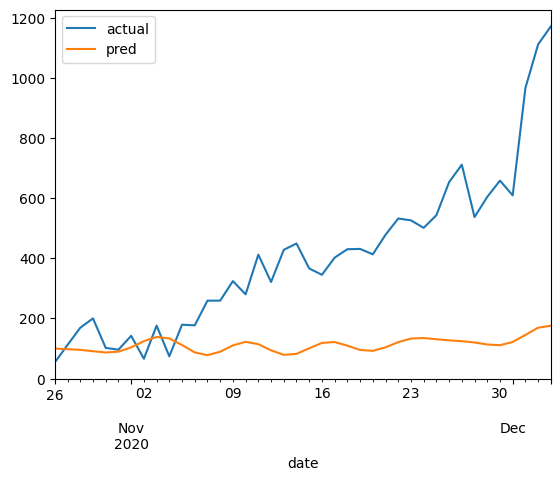

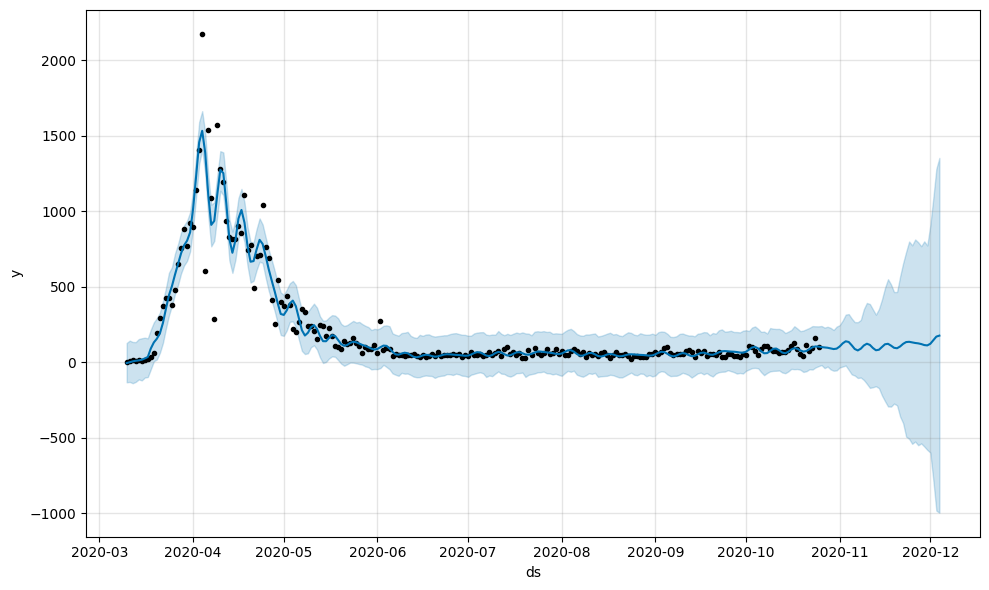

In [ ]:
model = Prophet(**best_param, yearly_seasonality = False,
                daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

model.plot(pred);

In [ ]:
param_grid = {
    'changepoint_prior_scale': [8, 9, 10, 11, 12],
    'seasonality_prior_scale': [2, 3, 4],
    'holidays_prior_scale':[0.007, 0.008, 0.009],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality':[True, False]
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2, 'weekly_seasonality': True} with mean MSE: 8927.394310993486
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2, 'weekly_seasonality': False} with mean MSE: 1808.8611168062998
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3, 'weekly_seasonality': True} with mean MSE: 8121.4897133867935
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3, 'weekly_seasonality': False} with mean MSE: 1973.1126177654412
params: {'changepoint_prior_scale': 8, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4, 'weekly_seasonality': True} with mean MSE: 9177.784109567574
params: {'changepoint_prior_sc

In [ ]:
param_grid = {
    'changepoint_prior_scale': [9, 10, 11],
    'seasonality_prior_scale': [3, 4, 5, 6],
    'holidays_prior_scale':[0.008, 0.009, 0.01],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality':[True, False]
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, yearly_seasonality = False,
                      daily_seasonality = False).add_country_holidays(
                          country_name='US').add_seasonality(
                              name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 9, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3, 'weekly_seasonality': True} with mean MSE: 8358.47921780838
params: {'changepoint_prior_scale': 9, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3, 'weekly_seasonality': False} with mean MSE: 2027.3839970030597
params: {'changepoint_prior_scale': 9, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4, 'weekly_seasonality': True} with mean MSE: 7603.289443839997
params: {'changepoint_prior_scale': 9, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4, 'weekly_seasonality': False} with mean MSE: 1668.8679543301944
params: {'changepoint_prior_scale': 9, 'holidays_prior_scale': 0.008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5, 'weekly_seasonality': True} with mean MSE: 8028.554365099105
params: {'changepoint_prior_scal

-1.1286389880791674


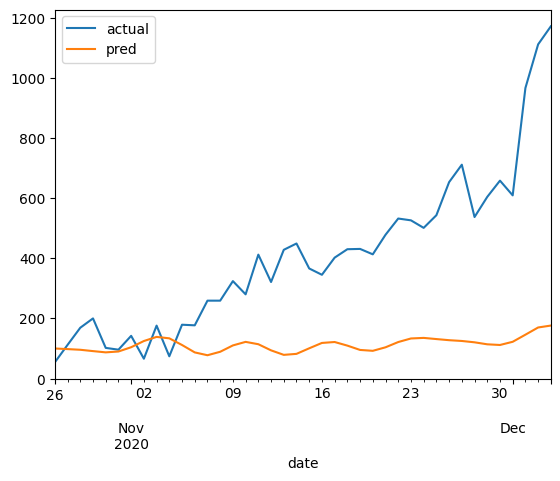

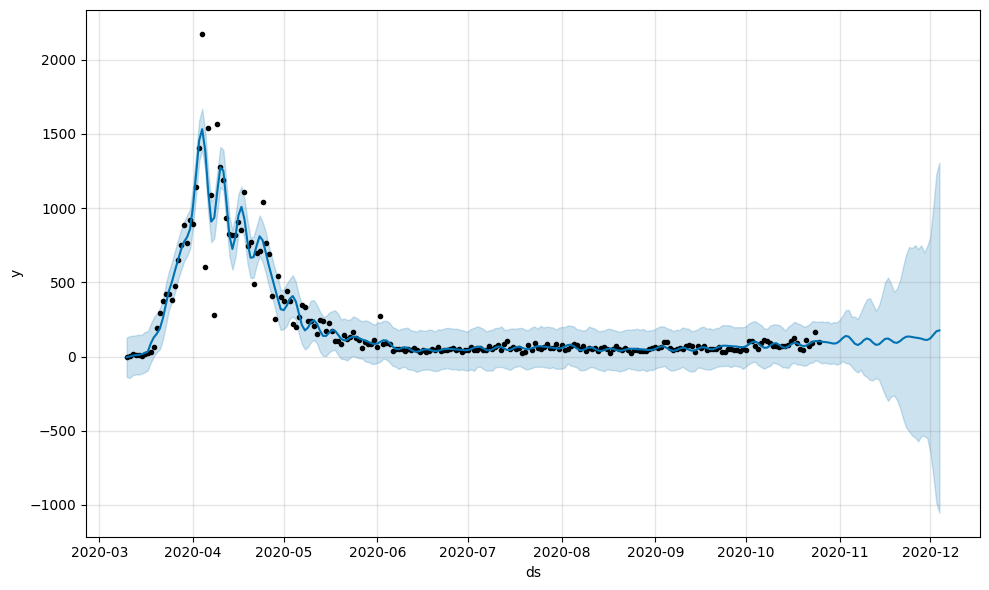

In [ ]:
model = Prophet(**best_param, yearly_seasonality = False,
                daily_seasonality = False).add_seasonality(
                          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

model.plot(pred);

In [ ]:
best_param

{'changepoint_prior_scale': 0.5,
 'daily_seasonality': True,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': True,
 'yearly_seasonality': True}

In [ ]:
Prophet(**param, holidays = events).add_country_holidays(country_name='US').fit(train_data)

In [ ]:
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 10],
    'holidays_prior_scale':[0.01, 0.1, 0.5, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality': [True, False],
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events).add_country_holidays(country_name='US').add_seasonality(
          name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 1604969.0922755168


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 1619089.1636981042


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 1959082.052982675


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 1838656.4960127336


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 1953101.1753030298


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 1882658.4254206188


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 1886236.8979633953


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 1850915.0092041509


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 1874287.8359108598


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 1837396.5741172722


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 1565117.451024253


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 1566308.0130053265


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 1938153.0536983146


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 1854342.9613438144


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 2446622.3665647586


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 2377474.165297492


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 2689111.0312701487


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 2583662.9477009303


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 2410914.52142029


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 2283687.8054736643


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 1889476.272165617


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 1815996.2866158958


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 2082243.5852660488


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 1893099.9099207472


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 2031032.2932108913


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 1965277.655193935


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 2071137.4478673616


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 1925187.4511122138


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 1921971.5895579795


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 1951328.4325095026


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 1728745.2886952448


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 1682412.106156862


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 2180760.48753172


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 2115398.8094392186


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 2492515.292212645


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 2428545.371122045


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 2545531.521001681


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 2380762.5218672077


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 2504504.8301004292


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 2368151.297929912


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 4430534.763181466


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 4233687.105436944


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 4825491.523463235


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 4529216.751407969


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 4735374.180677106


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 4386422.279222997


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 4662402.225366135


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 4498629.519974172


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 4467963.799687347


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 4333742.621242803


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 4422268.953759086


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 4422518.907876625


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 4528444.482629393


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 4504355.6358673265


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 4558250.225873717


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 4507507.005146022


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 4558796.638686228


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 4640712.883173558


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 4510645.451657643


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 4682891.217636625


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 4705049.921709262


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 4617344.795533944


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 5031221.753089343


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 4921845.176299993


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 4584197.798964632


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 4691932.456468647


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 4665206.586948334


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 4775210.330009822


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 4742251.247732635


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 4802159.078277592


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 4595269.695407645


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 4695535.885512345


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 4658075.384465603


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 4785698.967648773


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 4511826.1254531685


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 4858051.982826403


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 4760310.841945884


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 4685036.5277436515


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 4618632.616954416


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 4808438.390059651


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 4718433.836628373


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 4586512.95670832


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 5083548.167684962


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 4959045.539430565


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 4932050.603695503


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 4746793.189434681


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 4884910.178299861


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 4757664.829411834


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 4898922.886544921


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 4735235.496612288


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 4736996.232473732


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 4643299.691873948


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 4636259.397107602


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 4559042.08124899


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': True} with mean MSE: 4718018.108527589


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5, 'weekly_seasonality': False} with mean MSE: 4745101.195359374


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True} with mean MSE: 4689856.785944346


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False} with mean MSE: 4691956.580610293


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': True} with mean MSE: 4736209.731839609


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'weekly_seasonality': False} with mean MSE: 4714172.282125082
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True} with mean MSE: 1699490.1026958413
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} with mean MSE: 1504185.5064151625
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True} with mean MSE: 2132620.5344864163
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False} with mean MSE: 1641172.2772787597
pa

In [ ]:
best_param

{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 1.0,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 0.1}

-1.2781166739692305


<Axes: xlabel='date'>

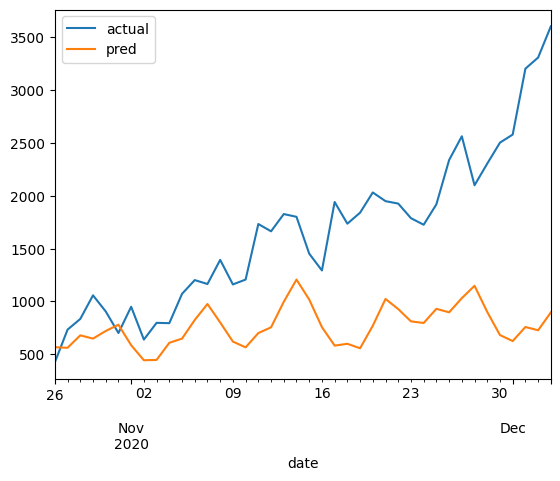

In [ ]:
model = Prophet(**best_param, holidays = events).add_country_holidays(country_name='US').add_seasonality(
          name='monthly', period=30.5, fourier_order=5).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 10],
    'holidays_prior_scale':[0.01, 0.1, 0.5, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param, holidays = events, weekly_seasonality = False).add_country_holidays(country_name='US').add_seasonality(
          name='monthly', period=30.5, fourier_order=5).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 1619089.1636981042


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 1838656.4960127336


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 1882658.4254206188


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 1850915.0092041509


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 1837396.5741172722


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 1566308.0130053265


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 1854342.9613438144


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 2377474.165297492


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 2583662.9477009303


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 2283687.8054736643


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 1815996.2866158958


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 1893099.9099207472


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 1965277.655193935


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 1925187.4511122138


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 1951328.4325095026


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 1682412.106156862


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 2115398.8094392186


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 2428545.371122045


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 2380762.5218672077


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 2368151.297929912


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 4233687.105436944


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 4529216.751407969


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 4386422.279222997


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 4498629.519974172


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 4333742.621242803


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 4422518.907876625


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 4504355.6358673265


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 4507507.005146022


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 4640712.883173558


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 4682891.217636625


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 4617344.795533944


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 4921845.176299993


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 4691932.456468647


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 4775210.330009822


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 4802159.078277592


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 4695535.885512345


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 4785698.967648773


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 4858051.982826403


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 4685036.5277436515


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 4808438.390059651


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 4586512.95670832


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 4959045.539430565


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 4746793.189434681


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 4757664.829411834


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean MSE: 4735235.496612288


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 4643299.691873948


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 4559042.08124899


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 4745101.195359374


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 4691956.580610293


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10} with mean MSE: 4714172.282125082
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 1504185.5064151625
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 1641172.2772787597
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 1845197.9332206126
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 1801432.0150334283
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10} with mean M

In [ ]:
model = Prophet(**param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

-1.0662468835715289


<Axes: xlabel='date'>

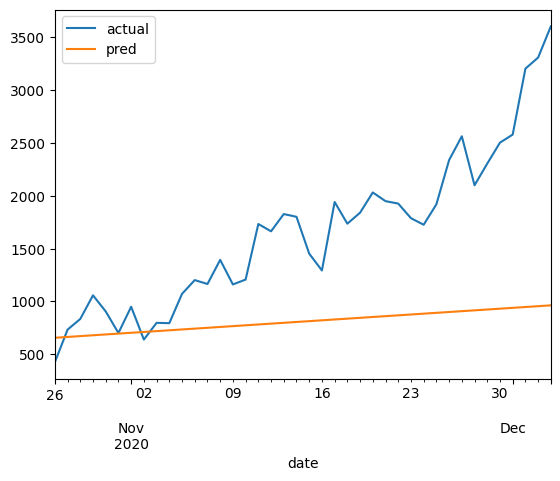

In [ ]:
model = Prophet(**param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

# Univariate Prophet

In [ ]:
nyc = data[data['entity'] == 'New York-New York City'].loc[:, ['date', 'incremental_cases']]
nyc['incremental_cases'] = nyc['incremental_cases'].astype('int')
nyc['date'] = pd.to_datetime(nyc['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = nyc.iloc[:230, :].rename(columns = {'date':'ds', 'incremental_cases':'y'})
test = nyc.iloc[230:, :]

# NYC data is stationary without any differencing
print(stationary_test(train.y))

(-4.027742630367559, 0.0012720104380451068)


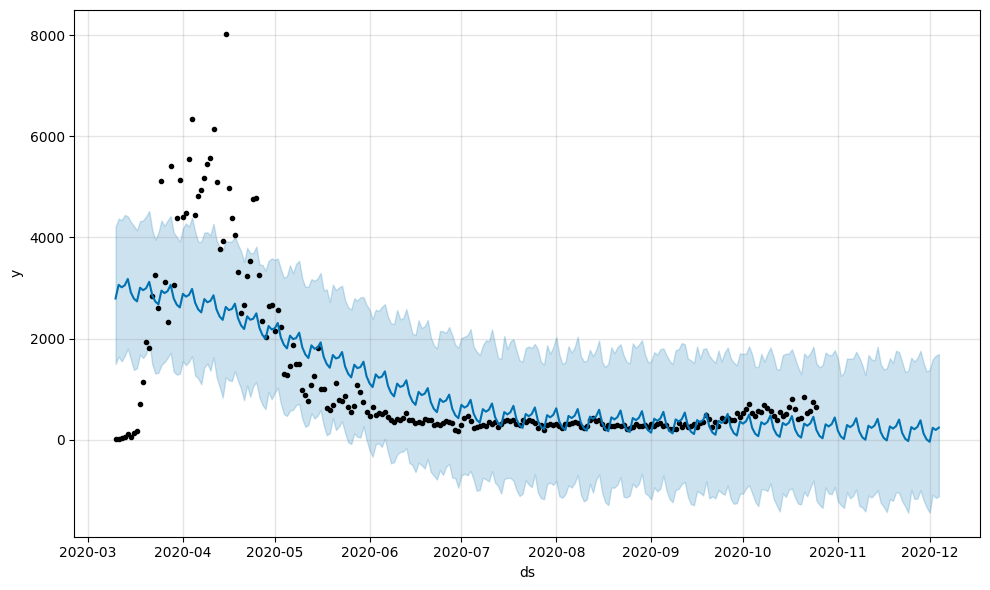

In [ ]:
model = Prophet().fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

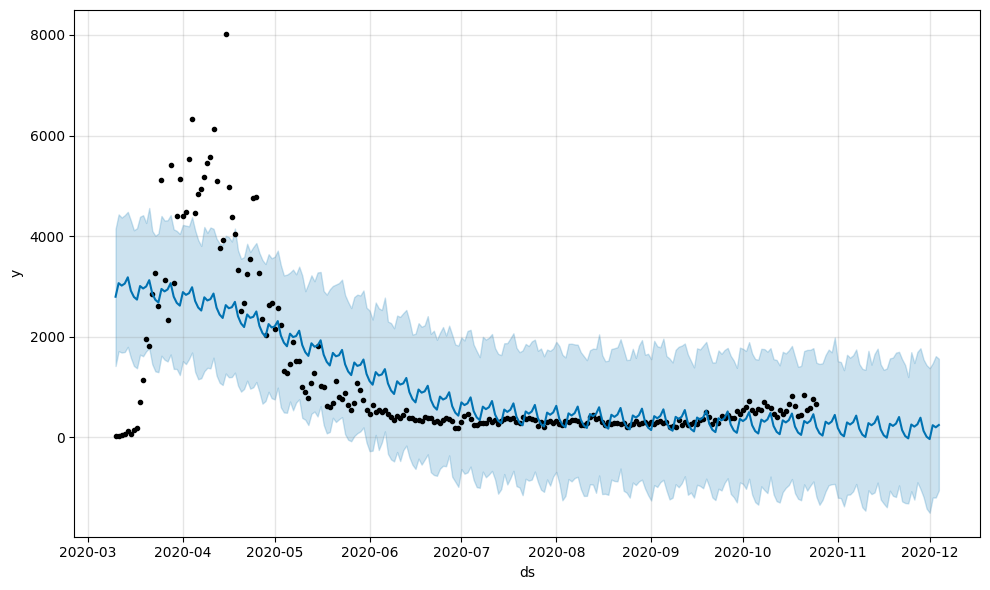

In [ ]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

-3.866424055369242


<Axes: xlabel='date'>

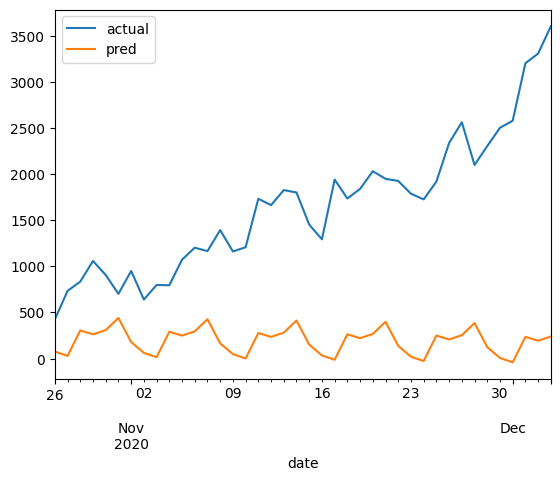

In [ ]:
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
tscv = TimeSeriesSplit(n_splits = 5)

train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 24022509.902335506


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 24045688.499234576


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 25447988.24518862


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 24119485.750381846


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 25905948.7448229


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 23652886.61148454


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 24022509.902335506


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 24045688.499234576


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 25447988.24518862


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 24119485.750381846


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 25905948.7448229


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 23652886.61148454


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 24022509.902335506


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 24045688.499234576


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 25447988.24518862


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 24119485.750381846


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 25905948.7448229


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 23652886.61148454
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 24121847.39662145
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 24044876.559156273
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 23800333.93202256
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 24330212.95235014
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1

-1.5587111668777816


<Axes: xlabel='date'>

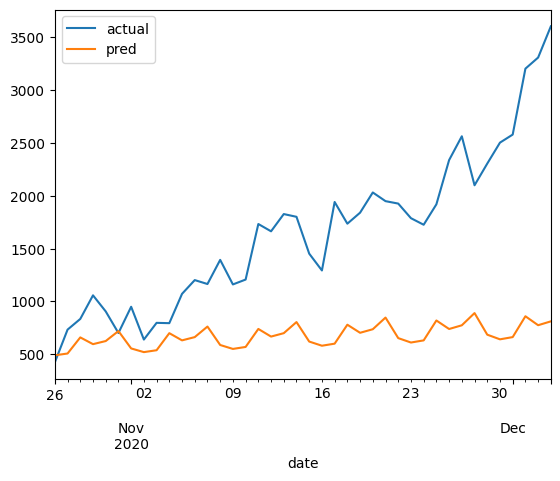

In [ ]:
model = Prophet(**best_param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.05, 0.075, 0.1, 0.125, 0.15],
    'seasonality_prior_scale': [0.05, 0.075, 0.1, 0.125, 0.15],
    'holidays_prior_scale': [0.005, 0.01, 0.015, 0.02],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 25743432.701915894
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.075} with mean MSE: 25790126.413834292
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 25466119.417116057
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.125} with mean MSE: 25676519.168601677
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.15} with mean MSE: 25676579.355273675
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0

-1.5052319063067783


<Axes: xlabel='date'>

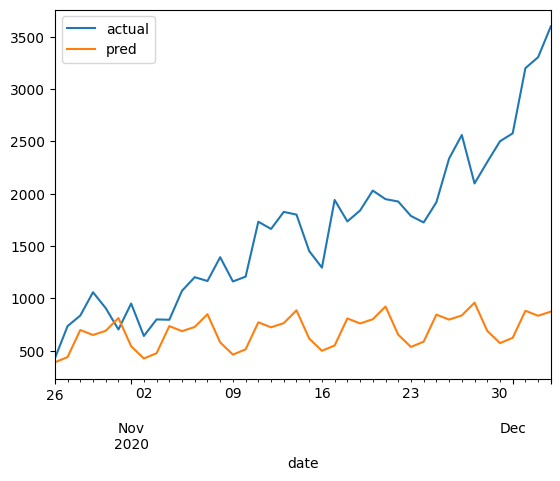

In [ ]:
model = Prophet(**best_param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

# Multivariate Prophet

In [ ]:
nyc = data[data['entity'] == 'New York-New York City'].drop(columns = 'cases')
nyc['incremental_cases'] = nyc['incremental_cases'].astype('int')
nyc['date'] = pd.to_datetime(nyc['date'], format="%Y-%m-%d")
nyc['stay_at_home_announced'] = nyc['stay_at_home_announced'].map({'yes':1, 'no':0})
nyc['stay_at_home_effective'] = nyc['stay_at_home_effective'].map({'yes':1, 'no':0})

non_static = []
def static_check(df):
  for i in df.columns:
    num_unique = len(df[i].unique())
    if num_unique != 1:
      non_static.append(i)
  return non_static

static_check(nyc)
nyc = nyc.loc[:, non_static].drop(columns = 'station_name').rename(columns = {'date':'ds', 'incremental_cases':'y'})

train = nyc.iloc[:230, :]
test = nyc.iloc[230:, :]

In [ ]:
nyc.columns

Index(['ds', 'stay_at_home_announced', 'stay_at_home_effective', 'mean_temp',
       'min_temp', 'max_temp', 'dewpoint', 'sea_level_pressure', 'visibility',
       'wind_speed', 'max_wind_speed', 'precipitation', 'precip_flag', 'fog',
       'rain', 'snow', 'hail', 'thunder', 'tornado', 'mean_temp_3d_avg',
       'max_temp_3d_avg', 'min_temp_3d_avg', 'dewpoint_3d_avg', 'y'],
      dtype='object')

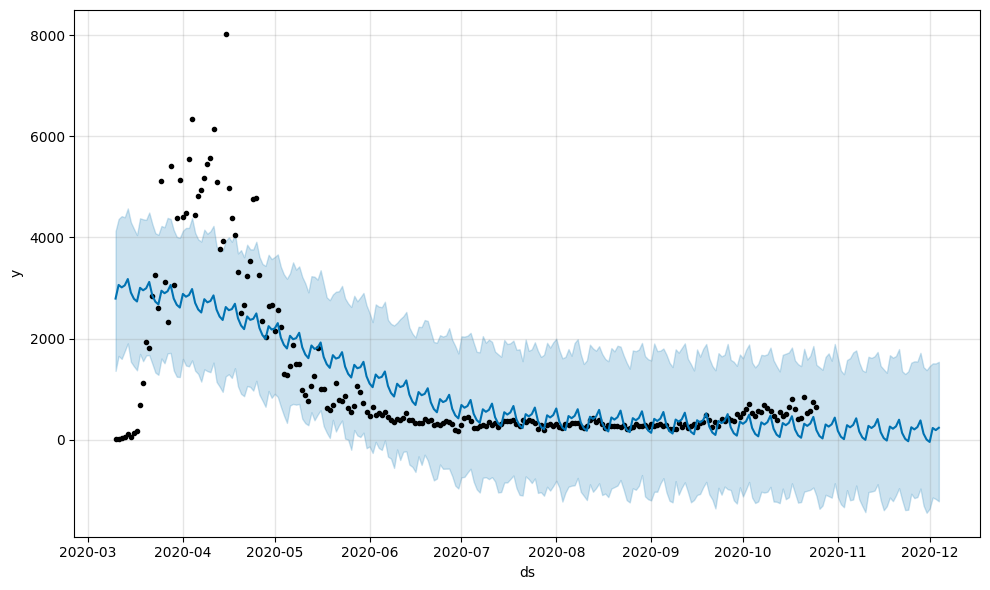

In [ ]:
# baseline model
model_baseline = Prophet()
model_baseline.fit(train)

future_baseline = model_baseline.make_future_dataframe(periods=40)
forecast_baseline = model_baseline.predict(future_baseline)
model_baseline.plot(forecast_baseline);

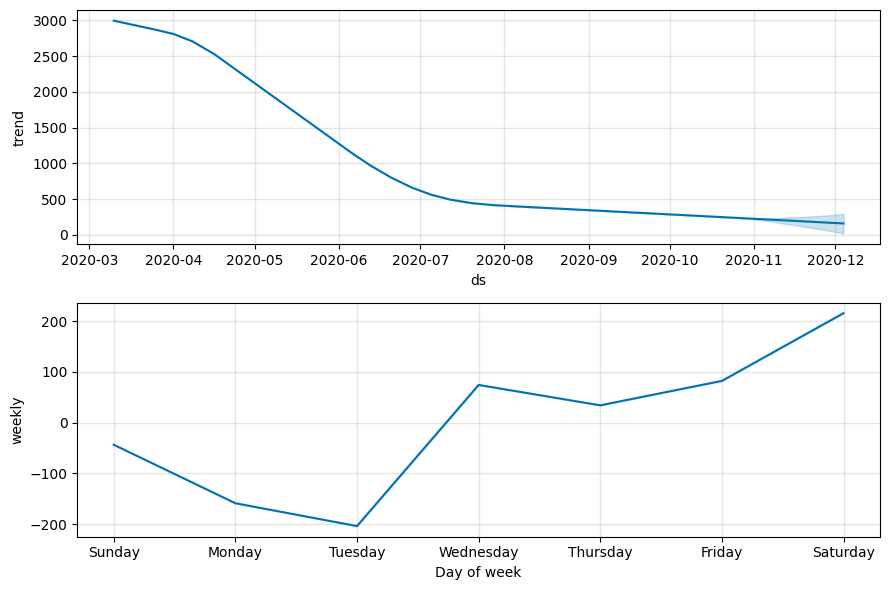

In [ ]:
model_baseline.plot_components(forecast_baseline);

In [ ]:
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 1461.1566112952082
The MAPE for the baseline model is 0.8570759844057416


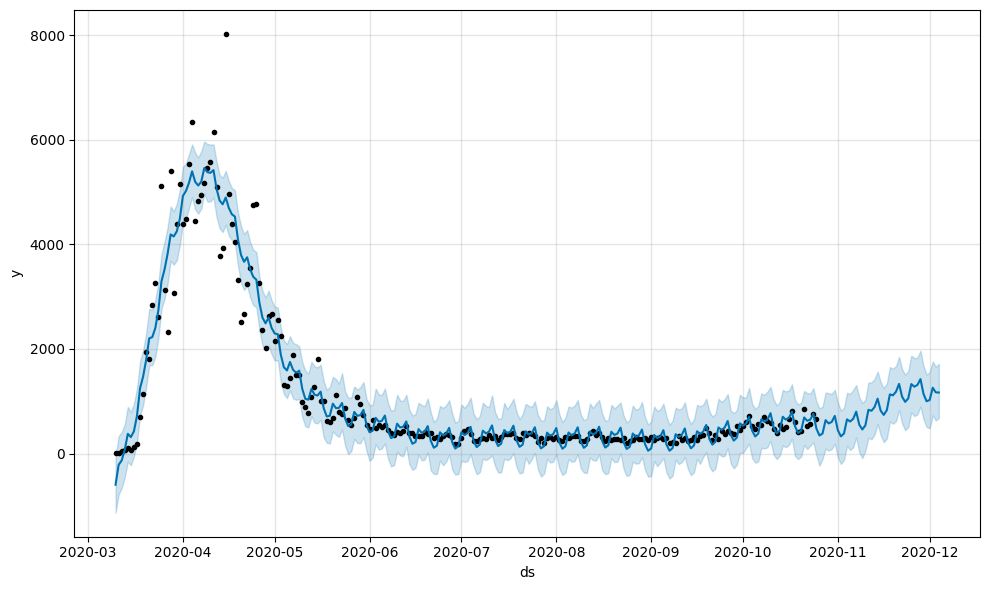

In [ ]:
# Add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model_season.fit(train)
future_season = model_season.make_future_dataframe(periods=40)
forecast_season = model_season.predict(future_season)
model_season.plot(forecast_season);

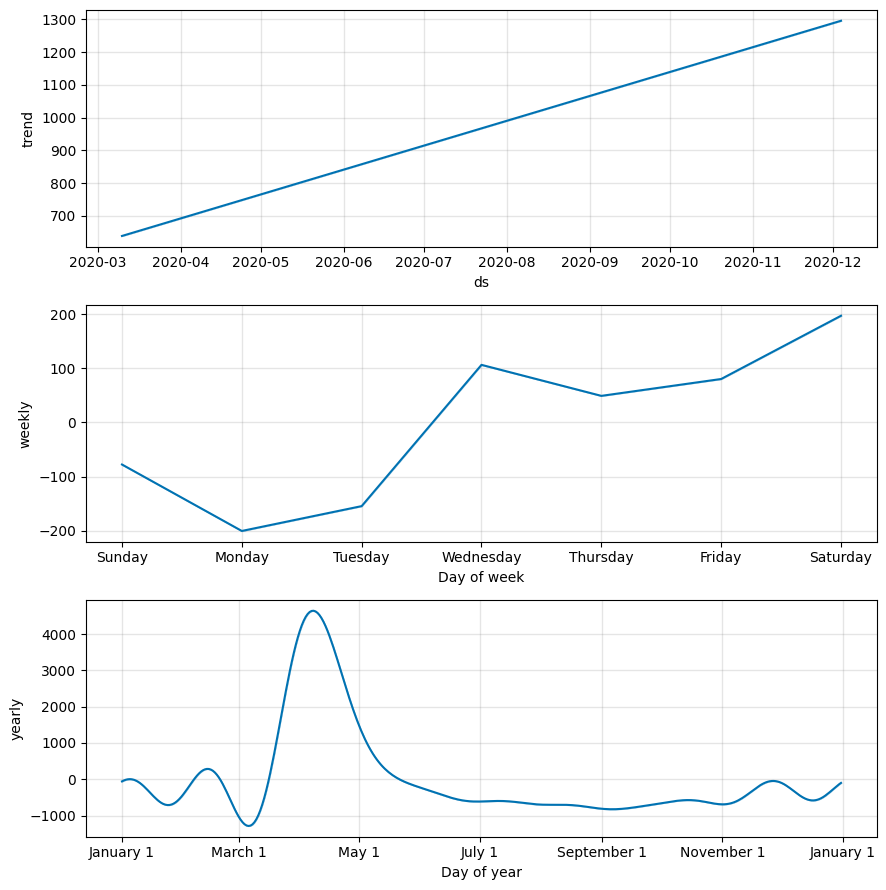

In [ ]:
model_season.plot_components(forecast_season);

In [ ]:
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 787.8966713720905
The MAPE for the seasonality model is 0.4434365062923038


-0.607206395200864


<Axes: xlabel='date'>

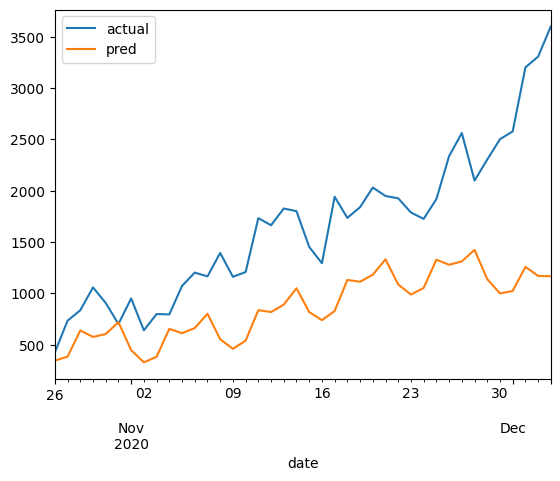

In [ ]:
r2 = r2_score(test.y, forecast_season.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':forecast_season.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = nyc.iloc[:230, :]
test = nyc.iloc[230:, :]
train = train.ffill()

model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate.add_regressor('stay_at_home_announced', standardize=False)
model_multivariate.fit(train)

In [ ]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=40)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, nyc[['ds', 'stay_at_home_announced']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

ds  stay_at_home_announced
260 2020-11-25                       1
261 2020-11-26                       1
262 2020-11-27                       1
263 2020-11-28                       1
264 2020-11-29                       1
265 2020-11-30                       1
266 2020-12-01                       1
267 2020-12-02                       1
268 2020-12-03                       1
269 2020-12-04                       1

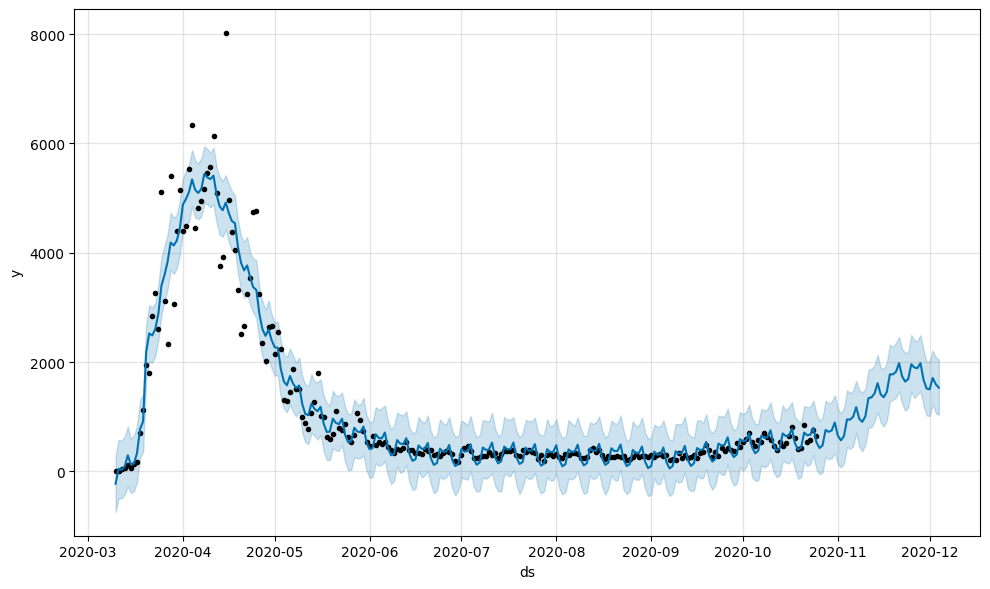

In [ ]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

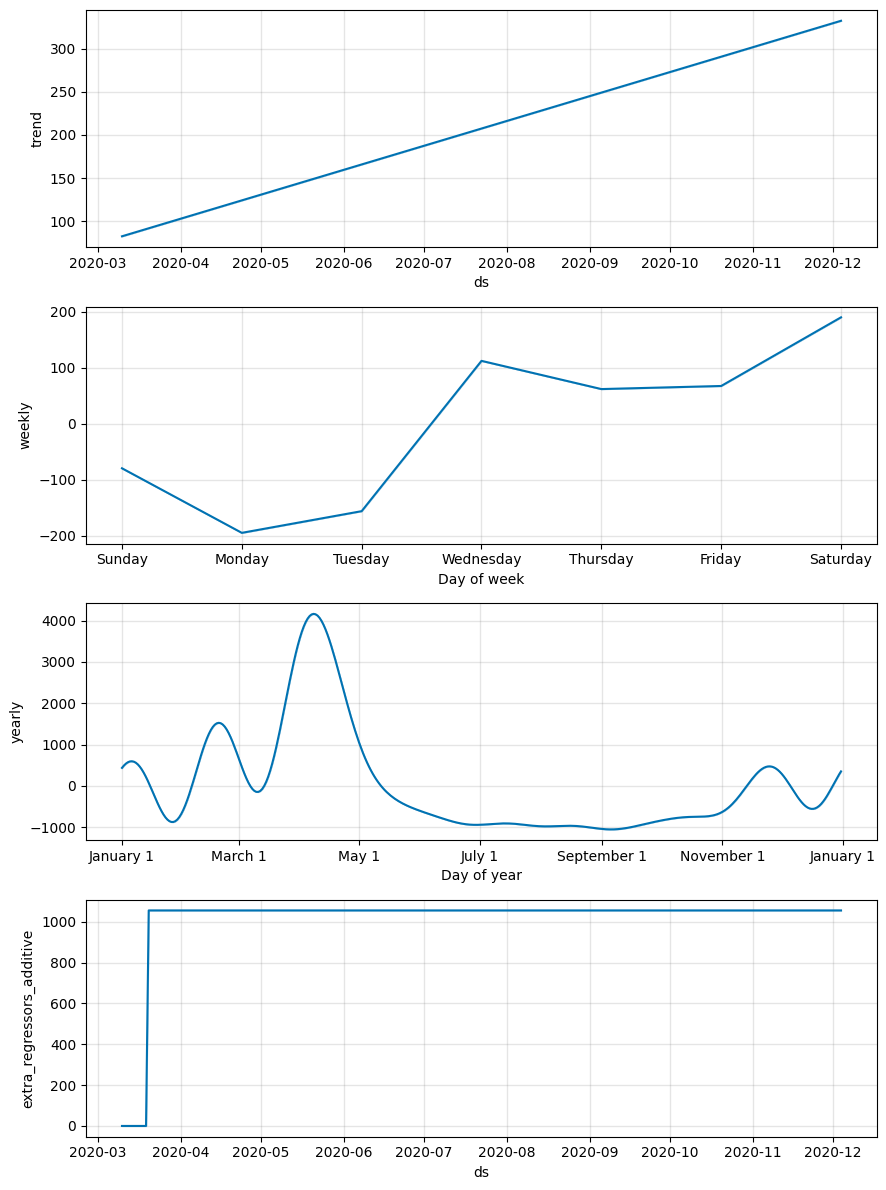

In [ ]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [ ]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 367.4716049196155
The MAPE for the multivariate model is 0.1899817837521515


0.3670070897419624


<Axes: xlabel='date'>

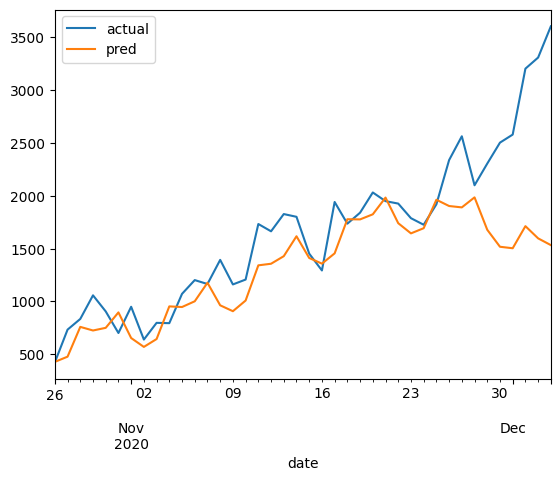

In [ ]:
pred = forecast_multivariate.loc[:, ['ds', 'yhat']][-40:].yhat
r2 = r2_score(test.y, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.ds.reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model_multivariate.add_regressor('stay_at_home_effective', standardize=False)
model_multivariate.add_regressor('stay_at_home_announced', standardize=False)
model_multivariate.fit(train)
future_multivariate = model_multivariate.make_future_dataframe(periods=40)
future_multivariate = pd.merge(future_multivariate, nyc[['ds', 'stay_at_home_effective', 'stay_at_home_announced']], on='ds', how='inner')
future_multivariate = future_multivariate.fillna(method='ffill')
future_multivariate.tail(10)

ds  stay_at_home_effective  stay_at_home_announced
260 2020-11-25                       1                       1
261 2020-11-26                       1                       1
262 2020-11-27                       1                       1
263 2020-11-28                       1                       1
264 2020-11-29                       1                       1
265 2020-11-30                       1                       1
266 2020-12-01                       1                       1
267 2020-12-02                       1                       1
268 2020-12-03                       1                       1
269 2020-12-04                       1                       1

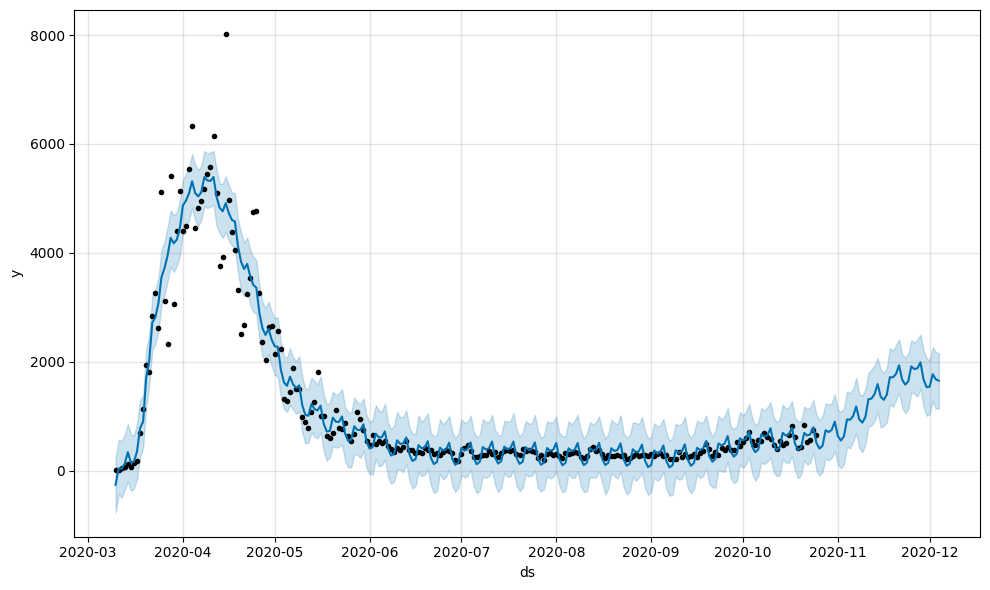

In [ ]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

In [ ]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 375.5247849979175
The MAPE for the multivariate model is 0.19904716786635798


0.3966835223758527


<Axes: xlabel='date'>

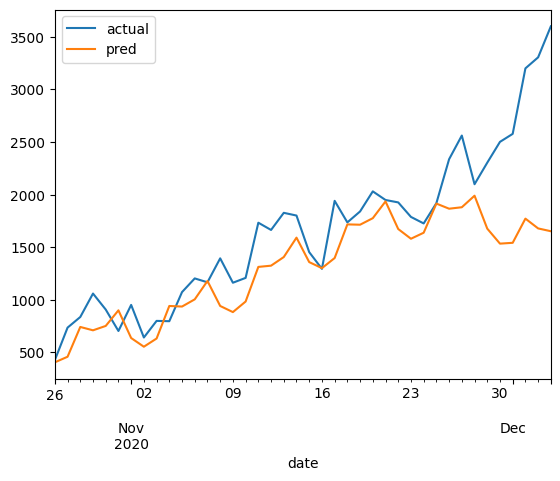

In [ ]:
pred = forecast_multivariate.loc[:, ['ds', 'yhat']][-40:].yhat
r2 = r2_score(test.y, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.ds.reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
non_static_col = ['stay_at_home_announced', 'stay_at_home_effective', 'mean_temp',
       'min_temp', 'max_temp', 'dewpoint', 'sea_level_pressure', 'visibility',
       'wind_speed', 'max_wind_speed', 'precipitation', 'fog',
       'rain', 'snow', 'hail', 'thunder', 'tornado', 'mean_temp_3d_avg',
       'max_temp_3d_avg', 'min_temp_3d_avg', 'dewpoint_3d_avg']

model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)
for i in non_static_col:
  model_multivariate.add_regressor(i, standardize=False)
model_multivariate.fit(train)

In [ ]:
non_static_col.append('ds')

In [ ]:
future_multivariate = model_multivariate.make_future_dataframe(periods=40)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, nyc[non_static_col], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

ds  stay_at_home_announced  stay_at_home_effective  mean_temp  \
260 2020-11-25                       1                       1       49.6   
261 2020-11-26                       1                       1       58.8   
262 2020-11-27                       1                       1       55.8   
263 2020-11-28                       1                       1       52.8   
264 2020-11-29                       1                       1       48.5   
265 2020-11-30                       1                       1       55.7   
266 2020-12-01                       1                       1       53.0   
267 2020-12-02                       1                       1       41.1   
268 2020-12-03                       1                       1       41.7   
269 2020-12-04                       1                       1       41.7   

     min_temp  max_temp  dewpoint  sea_level_pressure  visibility  wind_speed  \
260      42.1      55.0      36.0              1027.8        10.0         5.0   
261      46.9      64.9      51.4              1018.1         9.5         4.0   
262      51.1      64.9      46.7              1017.4        10.0         4.4   
263      50.0      64.0      39.0              1015.6        10.0         4.2   
264      43.0      59.0      31.6              1020.4        10.0         4.6   
265      50.0      62.6      48.4              1010.9         8.0         8.4   
266      43.0      62.1      46.2              1001.3         9.8        10.5   
267      37.9      59.0      29.5              1012.9        10.0        15.7   
268      36.0      52.0      27.9              1022.2        10.0         9.8   
269      36.0      52.0      27.9              1022.2        10.0         9.8   

     ...  fog  rain  snow  hail  thunder  tornado  mean_temp_3d_avg  \
260  ...  0.0   0.0   0.0   0.0      0.0      0.0         51.600000   
261  ...  0.0   1.0   0.0   0.0      0.0      0.0         54.733333   
262  ...  0.0   0.0   0.0   0.0      0.0      0.0         55.800000   
263  ...  0.0   0.0   0.0   0.0      0.0      0.0         52.366667   
264  ...  0.0   0.0   0.0   0.0      0.0      0.0         52.333333   
265  ...  0.0   1.0   0.0   0.0      0.0      0.0         52.400000   
266  ...  0.0   1.0   0.0   0.0      0.0      0.0         49.933333   
267  ...  0.0   0.0   0.0   0.0      0.0      0.0         45.266667   
268  ...  0.0   0.0   0.0   0.0      0.0      0.0         45.266667   
269  ...  0.0   0.0   0.0   0.0      0.0      0.0         45.266667   

     max_temp_3d_avg  min_temp_3d_avg  dewpoint_3d_avg  
260        59.633333        43.700000        39.100000  
261        61.600000        46.700000        44.700000  
262        64.600000        49.333333        45.700000  
263        62.633333        48.033333        39.100000  
264        61.866667        47.666667        39.666667  
265        61.233333        45.333333        42.066667  
266        61.233333        43.633333        41.366667  
267        57.700000        38.966667        34.533333  
268        57.700000        38.966667        34.533333  
269        57.700000        38.966667        34.533333  

[10 rows x 22 columns]

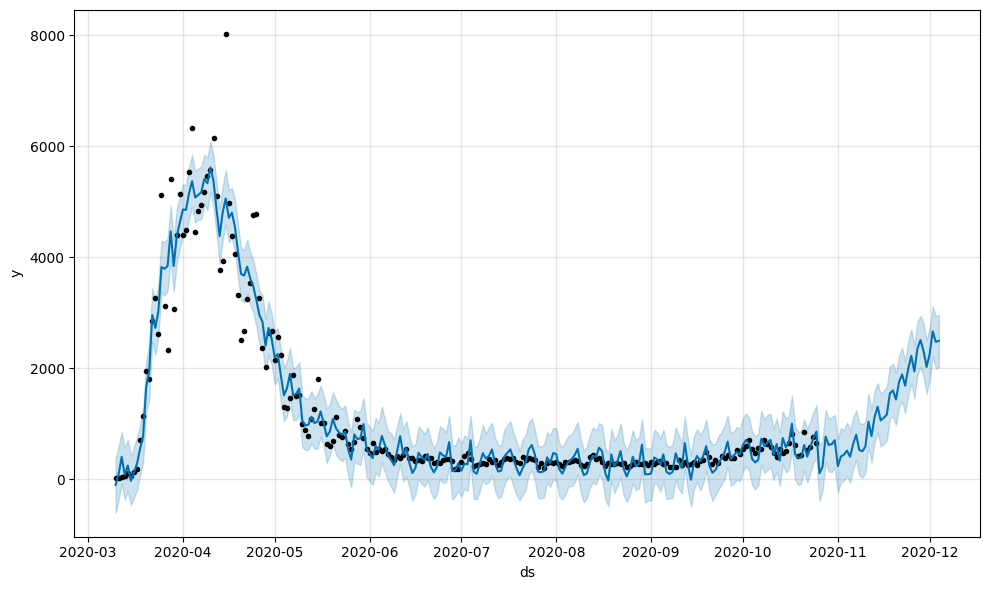

In [ ]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

In [ ]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 434.4428561951416
The MAPE for the multivariate model is 0.3064411040431297


0.5365234797667363


<Axes: xlabel='date'>

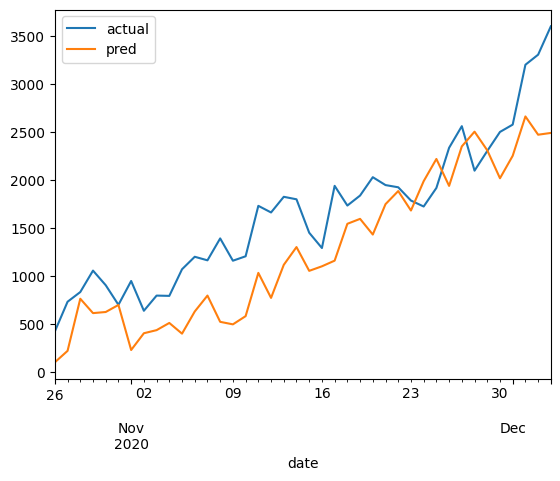

In [ ]:
pred = forecast_multivariate.loc[:, ['ds', 'yhat']][-40:].yhat
r2 = r2_score(test.y, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.ds.reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=events)

# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')

# Add regressor
model_holiday.add_regressor('stay_at_home_announced', standardize=False)

# Fit the model on the training dataset
model_holiday.fit(train)

# All the holidays and events
model_holiday.train_holiday_names

0                           COVID
1                       superbowl
2                  New Year's Day
3                    Memorial Day
4                Independence Day
5     Independence Day (observed)
6                       Labor Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10     Martin Luther King Jr. Day
11          Washington's Birthday
12                   Columbus Day
dtype: object

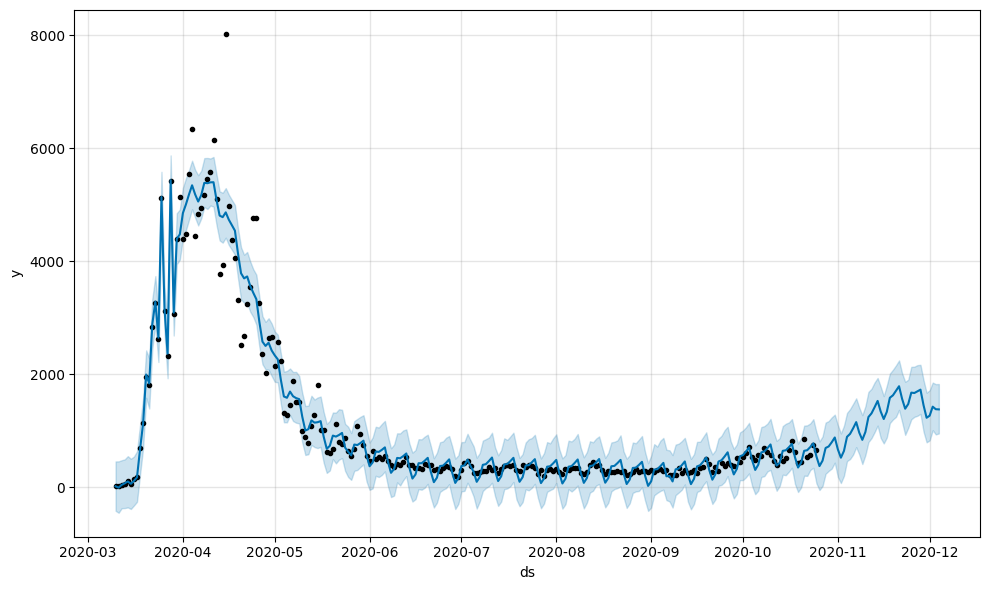

In [ ]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=40)

# Append the regressor values
future_holiday = pd.merge(future_holiday, nyc[['ds', 'stay_at_home_announced']], on='ds', how='inner')

# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')

# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)

# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

In [ ]:
# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')

# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

The MAE for the holiday/event model is 828.5121380476444
The MAPE for the holiday/event model is 0.3126717216948625


In [ ]:
# Add seasonality
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate.add_regressor('max_temp', standardize=False)

# Fit the model on the training dataset
model_multivariate.fit(nyc)

ValueError: Found NaN in column 'max_temp'

In [ ]:


# Assuming you have a DataFrame 'df' with timestamp, target variable, and related variables
# df = ...

# Separate target variable and related variables
target_variable = df[['timestamp', 'target_variable']]
related_variable_1 = df[['timestamp', 'related_variable_1']]
related_variable_2 = df[['timestamp', 'related_variable_2']]

# Prepare target variable DataFrame
target_variable.columns = ['ds', 'y']

# Create and fit Prophet model for target variable
model_target_variable = Prophet()
model_target_variable.fit(target_variable)

# Prepare related variable DataFrames
related_variable_1.columns = ['ds', 'y']
related_variable_2.columns = ['ds', 'y']

# Create and fit Prophet models for related variables
model_related_variable_1 = Prophet()
model_related_variable_1.fit(related_variable_1)

model_related_variable_2 = Prophet()
model_related_variable_2.fit(related_variable_2)

# Make forecasts
future_target_variable = model_target_variable.make_future_dataframe(periods=30)
forecast_target_variable = model_target_variable.predict(future_target_variable)

future_related_variable_1 = model_related_variable_1.make_future_dataframe(periods=30)
forecast_related_variable_1 = model_related_variable_1.predict(future_related_variable_1)

future_related_variable_2 = model_related_variable_2.make_future_dataframe(periods=30)
forecast_related_variable_2 = model_related_variable_2.predict(future_related_variable_2)

# Further processing and integration of forecasts as needed
